In [31]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **Open Data Search & Discovery**

A template workflow for determining what *datasets* from the most common openly disseminated *satellite* missions are available over a particular *region*. Various core and mirror *apis* are queried, completeness checks against an S3 or S3-like bucket are performed and joblists are created; i.e. ready for insertion to a redis queue.

Primary aim of the notebook is to ***generalise the creation of Jobs for undertaking ODC Data Preparation campaigns*** across any infrastructure (in-house vs public cloud vs local machine) and providing a means for assessing their successful completion.

### **Considerations**
*Preferred* apis for each dataset are constantly evolving. Some broader industry trends (conveniently) should even make the Data Preparation component of ODC redundant (i.e. Landsat Collection 2 due to be released on S3 bucket with appropriate STAC metadata).

Additional dependencies may be required for proper 3rd party useage (i.e. creation and formatting of DEMs for Sentinel-1) within broader context of ard-docker-images and helm-charts tools.

Some sensor / API / component -specific considerations are captured in-line.

Some obvious improvements could be made. We note those that seem particularly pertinent below, but suggestions are welcome.

### **Likely next steps**
- speed up world tiles querying by inverting search
- speed up gcloud zipped csvs by parallelising(?)
- convert into functions/tools rather than nb


- **generalise AOI+DEM+joblist vars**
- **bring DEMs var to top & inc. option for download+mosaic+format+upload**

In [32]:
import geopandas as gpd
from shapely.geometry import Polygon
from shapely import wkt
from shapely import wkb
from fiona.crs import from_epsg
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.patches as mpatches

from sentinelsat import SentinelAPI
import pandas as pd
from datetime import datetime
from datetime import date
import glob
from collections import OrderedDict
import os
import csv
import random

import numpy as np

import requests
import json
import getpass

from tqdm import tqdm
from google.cloud import storage

from utils.prep_utils import s3_list_objects_paths, s3_list_objects, s3_list_objects_pathssize, s3_download, s3_upload_cogs, create_yaml, get_geometry
from utils.prepS1 import get_s1_asf_urls


In [33]:
def get_s2_csvfile(gc_path, loc_path): # should probs just use prepS2 download func...
    tmpjson = f"{inter_dir}tmpcreds.json"
    lines = ['{\n',
     f'  "client_email": "{os.getenv("GCP_CLIENT_EMAIL")}",\n',
     f'  "private_key": "{os.getenv("GCP_PRIVATE_KEY")}",\n',
     '  "token_uri": "https://oauth2.googleapis.com/token"\n',
     '}\n']
    with open(tmpjson, 'w') as cred:
        for line in lines:
            cred.write(line)
    
    client = storage.Client.from_service_account_json(tmpjson)
    bucket = client.bucket(bucket_name="gcp-public-data-sentinel-2")

    blobs = bucket.list_blobs(prefix=gc_path)  # Get list of files
    blob = [i for i in blobs][0]
    
    blob.download_to_filename(loc_path)

# **INPUTS**

In [74]:
# any country name OR wkt in epsg 4326
region = 'Vanuatu' 
# region = 'POLYGON((-4.56 51.67,-2.19 51.67,-2.19 50.33,-4.56 50.33,-4.56 51.67))' 
# region_name = 'UKSW' # only req if wkt (vs world borders country name)
region_bucket_name = 'vanuatu'
antimeridian = False

# if aoi is fiji and crosses anti-meridian, use local crs
if antimeridian:
    plot_crs = {"init": "epsg:3460"}
else:
    plot_crs = {"init": "epsg:4326"}
    
# need to update the acquisition csvs for S2/LS? if don't exist yet False is ok
update_acqs_s2_gcloud = False
update_acqs_ls_usgs = False

# local directory for any processing and outputs
inter_dir = '/tmp/data/' 
os.makedirs(f'{inter_dir}ancillary', exist_ok=True)
os.makedirs(f'{inter_dir}outputs', exist_ok=True)

# **Check Req Envs**

In [35]:
# should inc. sedas creds
source_envars = {
    'ESAHUB':['COPERNICUS_USERNAME','COPERNICUS_PWD'],
    'ASF':['ASF_USERNAME','ASF_PWD'],
    'USGS':['USGS_USERNAME','USGS_PWD'],
    'GCP': ['GCP_PRIVATE_KEY', 'GCP_CLIENT_EMAIL']
}

In [36]:
for envars in source_envars:
    for var in source_envars[envars]:
        print(var,':',os.getenv(var)!=None)

COPERNICUS_USERNAME : True
COPERNICUS_PWD : True
ASF_USERNAME : True
ASF_PWD : True
USGS_USERNAME : True
USGS_PWD : True
GCP_PRIVATE_KEY : True
GCP_CLIENT_EMAIL : True


# **Download any necessary AoI Vectors and Ancillary datasets**

In [37]:
# local paths
anc_dir = f'{inter_dir}ancillary/'
anc_dir_rem = 'common_sensing/ancillary_products/'
anc_paths = {
    's2tiles_path': [f'{anc_dir}sentinel2_tiles_world.geojson',f'{anc_dir_rem}SatelliteSceneTiles/sentinel2_tiles_world/sentinel2_tiles_world.geojson'],
    'lstiles_path': [f'{anc_dir}WRS2_descending.geojson',f'{anc_dir_rem}SatelliteSceneTiles/landsat_pr/WRS2_descending.geojson'],
    'wborders_path': [f'{anc_dir}TM_WORLD_BORDERS.geojson',f'{anc_dir_rem}TM_WORLD_BORDERS/TM_WORLD_BORDERS.geojson'],
    's2l1csv_path': [f'{anc_dir}L1_index.csv.gz','index.csv.gz'],
    's2l2csv_path': [f'{anc_dir}L2_index.csv.gz','L2/index.csv.gz'],
    'ls8csv_path': [f'{anc_dir}LANDSAT_8_C1_new.csv.gz','https://landsat.usgs.gov/landsat/metadata_service/bulk_metadata_files/LANDSAT_8_C1.csv.gz'],
    'ls7csv_path': [f'{anc_dir}LANDSAT_7_C1_new.csv.gz','https://landsat.usgs.gov/landsat/metadata_service/bulk_metadata_files/LANDSAT_ETM_C1.csv.gz'],
    'ls45csv_path': [f'{anc_dir}LANDSAT_45_C1_new.csv.gz','https://landsat.usgs.gov/landsat/metadata_service/bulk_metadata_files/LANDSAT_TM_C1.csv.gz'],
    'ls12csv_path': [f'{anc_dir}LANDSAT_12_C1_new.csv.gz','https://landsat.usgs.gov/landsat/metadata_service/bulk_metadata_files/LANDSAT_MSS_C1.csv.gz']
}

In [38]:
loc_anc_exists = dict(zip(anc_paths.keys(), [os.path.exists(anc_paths[i][0]) for i in anc_paths]))
print(loc_anc_exists)

{'s2tiles_path': True, 'lstiles_path': True, 'wborders_path': True, 's2l1csv_path': True, 's2l2csv_path': True, 'ls8csv_path': True, 'ls7csv_path': True, 'ls45csv_path': True, 'ls12csv_path': True}


In [39]:
%%time
# get fixed anc files
fixed_ancs = ['s2tiles_path','lstiles_path','wborders_path']
for f in tqdm(fixed_ancs):
    if os.path.exists(anc_paths[f][0]) == False:
        print(f'Downloading {anc_paths[f][1]}')
        s3_download(s3_bucket, anc_paths[f][1], anc_paths[f][0])
        print(f'Downloaded {anc_paths[f][1]}')        
    else:
        print(f'{anc_paths[f][0]} already available')
        
# get variable anc files if unavailable or need to be updated
var_ancs_gc = ['s2l1csv_path','s2l2csv_path']
for f in tqdm(var_ancs_gc):    
    if (os.path.exists(anc_paths[f][0]) == False) | (update_acqs_s2_gcloud == True):
        print(f'Downloading {anc_paths[f][1]}')
        get_s2_csvfile(anc_paths[f][1], anc_paths[f][0])
        print(f'Downloaded {anc_paths[f][1]}')
    else:
        print(f'{anc_paths[f][0]} already available')
var_ancs_urls = ['ls8csv_path','ls7csv_path','ls45csv_path','ls12csv_path']
for f in tqdm(var_ancs_urls):
    if (os.path.exists(anc_paths[f][0]) == False) | (update_acqs_ls_usgs == True):
        print(f'Downloading {anc_paths[f][1]}')
        open(f'{anc_paths[f][0]}', 'wb').write(requests.get(anc_paths[f][1]).content)
        print(f'Downloaded {anc_paths[f][1]}')
    else:
        print(f'{anc_paths[f][0]} already available')

100%|██████████| 4/4 [00:00<00:00, 1304.60it/s]

/tmp/data/ancillary/sentinel2_tiles_world.geojson already available
/tmp/data/ancillary/WRS2_descending.geojson already available
/tmp/data/ancillary/TM_WORLD_BORDERS.geojson already available
/tmp/data/ancillary/L1_index.csv.gz already available
/tmp/data/ancillary/L2_index.csv.gz already available
/tmp/data/ancillary/LANDSAT_8_C1_new.csv.gz already available
/tmp/data/ancillary/LANDSAT_7_C1_new.csv.gz already available
/tmp/data/ancillary/LANDSAT_45_C1_new.csv.gz already available
/tmp/data/ancillary/LANDSAT_12_C1_new.csv.gz already available
CPU times: user 14.2 ms, sys: 10.1 ms, total: 24.3 ms
Wall time: 15.9 ms


# **CREATE AOI**

POLYGON ((166.5166630000001 -20.254169, 170.2352290000001 -20.254169, 170.2352290000001 -13.070555, 166.5166630000001 -13.070555, 166.5166630000001 -20.254169))


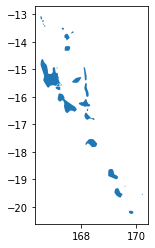

In [40]:
world_borders = gpd.read_file(anc_paths['wborders_path'][0])
if region in world_borders.NAME.values:
    aoi = world_borders.loc[world_borders.NAME == region]
    region_name = region
else:
    aoi = pd.DataFrame(data={'geometry': [region]})
    aoi['geometry'] = aoi['geometry'].apply(wkt.loads)
    aoi = gpd.GeoDataFrame(aoi, geometry='geometry', crs=('epsg:4326'))
    aoi['NAME'] = region_name
    region_name = region_name
aoi_wkt = aoi.to_crs(plot_crs).envelope.to_crs({"init": "epsg:4326"}).values[0].wkt
print(aoi_wkt)
aoi.to_crs(plot_crs).plot();

# **SENTINEL_2**

### DETERMINE OVERLAPPING GRANULES

In [41]:
# load world granules
world_granules = gpd.read_file(anc_paths['s2tiles_path'][0])
# Create bool for intersection between any tiles - should try inversion to speed up...
for n, g in zip(aoi.NAME, aoi.geometry):
    world_granules[n] = world_granules.geometry.apply(lambda x: gpd.GeoSeries(x).intersects(g))
# Filter based on any True intersections
world_granules[region_name] = world_granules[world_granules[aoi.NAME.values]].any(1)
region_s2_grans = world_granules[world_granules[region_name]==True]

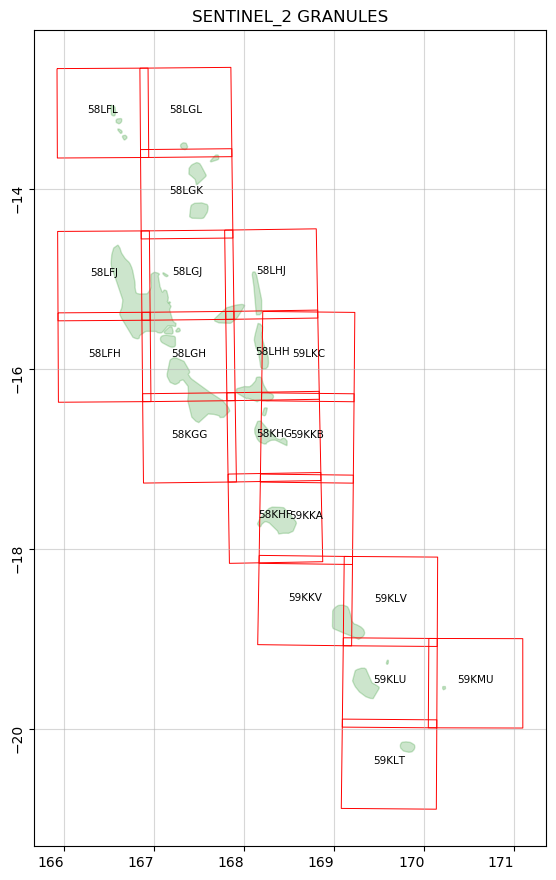

In [42]:
# Plot coverage
fig, ax = plt.subplots(figsize=(12,12),dpi=100)
fig.autofmt_xdate()
leg_patches=[]

x = aoi.to_crs(plot_crs).plot(facecolor="g", edgecolor='g', ax=ax, alpha=0.2);
leg_patches.append(mpatches.Patch(facecolor="g", edgecolor='g', alpha=0.25, lw=0.7, label=region_name))

x = region_s2_grans.to_crs(plot_crs).plot(facecolor="none", edgecolor='r', lw=0.7, ax=ax)
leg_patches.append(mpatches.Patch(facecolor="none", edgecolor='r', lw=0.7, label='Sentinel-2 Tiles'))
region_s2_grans.to_crs(plot_crs).apply(lambda x: ax.annotate(s=x.Name, xy=x.geometry.centroid.coords[0], ha='center', fontsize=7.5),axis=1)

ax.set_title('SENTINEL_2 GRANULES')
ax.grid(alpha=0.5);
ax.tick_params(axis='y', rotation=90);
ax.tick_params(axis='x', rotation=0);

### ESA QUERY

In [43]:
# Login to esa api
esa_api = SentinelAPI(os.environ['COPERNICUS_USERNAME'],os.environ['COPERNICUS_PWD'])

In [44]:
# l2a results
res = esa_api.query(aoi_wkt, platformname='Sentinel-2',producttype='S2MSI2A')
esa_l2a = esa_api.to_geodataframe(res)

Querying products: 100%|██████████| 9118/9118 [01:13<00:00, 124.80 products/s]


In [45]:
# l1c results
res = esa_api.query(aoi_wkt, platformname='Sentinel-2', producttype='S2MSI1C')
esa_l1c = esa_api.to_geodataframe(res)
l1c = esa_l1c

Querying products: 100%|██████████| 19066/19066 [02:24<00:00, 132.28 products/s]


In [46]:
# Add shortened scene name
esa_l1c['scenename'] = esa_l1c.title.apply(lambda x: f"{x.split('_')[0]}_{x.split('_')[1]}_{x.split('_')[2]}_{x.split('_')[5]}")
esa_l2a['scenename'] = esa_l2a.title.apply(lambda x: f"{x.split('_')[0]}_MSIL1C_{x.split('_')[2]}_{x.split('_')[5]}")
esa_l1c['granules'] = esa_l1c.identifier.str[39:44]
esa_l2a['granules'] = esa_l2a.identifier.str[39:44]

In [47]:
# CHECK EARLIEST ACQUISITIONS ALIGN WITH KNOWN AVAILABILITY
esa_l1c = esa_l1c.sort_values('beginposition', ascending=True)
esa_l2a = esa_l2a.sort_values('beginposition', ascending=True)
print(f'Tot. No. L1C Prods: {len(esa_l1c)} | Tot. No. L2A Prods: {len(esa_l2a)}')
print('First 2, last 2 products...')
print(list(esa_l1c.title.values[:2]))
print(list(esa_l2a.title.values[:2]))
print(list(esa_l1c.title.values[-2:]))
print(list(esa_l2a.title.values[-2:]))
print('Sorted...')
esa_l1c_srt = esa_l1c.sort_values('beginposition', ascending=False)
esa_l2a_srt = esa_l2a.sort_values('beginposition', ascending=False)
print(list(esa_l1c_srt.title.values[-2:]))
print(list(esa_l2a_srt.title.values[-2:]))

Tot. No. L1C Prods: 19066 | Tot. No. L2A Prods: 9118
First 2, last 2 products...
['S2A_MSIL1C_20151113T230022_N0204_R058_T58KHD_20151113T230019', 'S2A_MSIL1C_20151113T230022_N0204_R058_T59LKC_20151113T230019']
['S2A_MSIL2A_20181213T231841_N0211_R001_T58LGL_20181214T005852', 'S2A_MSIL2A_20181213T231841_N0211_R001_T58LFL_20181214T005852']
['S2B_MSIL1C_20200803T230029_N0209_R058_T59KLB_20200804T001425', 'S2B_MSIL1C_20200803T230029_N0209_R058_T59KMU_20200804T001425']
['S2A_MSIL2A_20200804T231901_N0214_R001_T58LGL_20200805T005001', 'S2A_MSIL2A_20200804T231901_N0214_R001_T58LFK_20200805T005001']
Sorted...
['S2A_MSIL1C_20151113T230022_N0204_R058_T59LKD_20151113T230019', 'S2A_MSIL1C_20151113T230022_N0204_R058_T58KHD_20151113T230019']
['S2A_MSIL2A_20181213T231841_N0211_R001_T58LFJ_20181214T005852', 'S2A_MSIL2A_20181213T231841_N0211_R001_T58LGL_20181214T005852']


In [48]:
# Filter L1C scenes that have already been processed to L2A
print(f'Tot No. L1C Scenes (AoI Envelope): {esa_l1c_srt.shape}')
esa_l1c_srt = esa_l1c_srt.loc[~esa_l1c_srt['scenename'].isin(esa_l2a_srt.scenename.values)]
print(f'No. nonL2A L1C Scenes (AoI Envelope): {esa_l1c_srt.shape}')
print(f'No. L2A Scenes (AoI Envelope): {esa_l2a_srt.shape}')

Tot No. L1C Scenes (AoI Envelope): (19066, 36)
No. nonL2A L1C Scenes (AoI Envelope): (9955, 36)
No. L2A Scenes (AoI Envelope): (9118, 37)


In [49]:
# Filter search results to specific tiles needed (i.e. from tiles shapefile)
esa_l1c_precise = esa_l1c_srt[esa_l1c_srt['granules'].isin(region_s2_grans.Name.values)]
esa_l2a_precise = esa_l2a_srt[esa_l2a_srt['granules'].isin(region_s2_grans.Name.values)]
print(f'No. nonL2A L1C Scenes (Precise Tiles): {esa_l1c_precise.shape}')
print(f'No. L2A Scenes (Precise Tiles): {esa_l2a_precise.shape}')

No. nonL2A L1C Scenes (Precise Tiles): (4375, 36)
No. L2A Scenes (Precise Tiles): (4053, 37)


### GCLOUD QUERY

In [50]:
# Get tile names from ESA S2 tiles shapefile (from above)
s2_tiles = list(region_s2_grans.Name.values)
len(s2_tiles)

20

In [51]:
# Read all GCloud L1C acquisitions and filter to those of desired tiles - takes too long
gc = pd.read_csv(anc_paths['s2l1csv_path'][0])
gc_l1c = gc[ gc.MGRS_TILE.isin(s2_tiles) ]
gc = None
# Read all GCloud L2A acquisitions and filter to those of desired tiles - takes too long
gc = pd.read_csv(anc_paths['s2l2csv_path'][0])
gc_l2a = gc[ gc.MGRS_TILE.isin(s2_tiles) ]
gc = None

In [52]:
# Create shortened name as with esa
print(f'Tot No. L2A GCloud Scenes (Precise Tiles): {gc_l2a.shape}')
print(f'Tot No. L1C GCloud Scenes (Precise Tiles): {gc_l1c.shape}')
gc_l2a['scenename'] = gc_l2a.PRODUCT_ID.apply(lambda x: f"{x.split('_')[0]}_MSIL1C_{x.split('_')[2]}_{x.split('_')[5]}")
gc_l1c['scenename'] = gc_l1c.PRODUCT_ID.apply(lambda x: f"{x.split('_')[0]}_MSIL1C_{x.split('_')[2]}_{x.split('_')[5]}")

Tot No. L2A GCloud Scenes (Precise Tiles): (4200, 14)
Tot No. L1C GCloud Scenes (Precise Tiles): (9281, 14)


In [53]:
# Filter to only scenes that match esa
gc_l2a_match = gc_l2a.loc[gc_l2a['scenename'].isin(esa_l2a_precise.scenename.values)]
gc_l1c_match = gc_l1c.loc[gc_l1c['scenename'].isin(esa_l1c_precise.scenename.values)]
print(f'Tot No. L2A GCloud cross-referenced Scenes (Precise Tiles): {gc_l2a_match.shape}')
print(f'Tot No. L2A GCloud cross-referenced Scenes (Precise Tiles): {gc_l1c_match.shape}')

Tot No. L2A GCloud cross-referenced Scenes (Precise Tiles): (4049, 15)
Tot No. L2A GCloud cross-referenced Scenes (Precise Tiles): (4313, 15)


In [54]:
# Filter L1C scenes that have already been processed to L2A
print(f'Tot No. L1C Scenes (Precise AoI): {gc_l1c_match.shape}')
gc_l1c_match = gc_l1c_match.loc[~gc_l1c_match['scenename'].isin(gc_l2a_match.scenename.values)]
print(f'No. nonL2A L1C Scenes (Precise AoI): {gc_l1c_match.shape}')
print(f'No. L2A Scenes (Precise AoI): {gc_l2a_match.shape}')

Tot No. L1C Scenes (Precise AoI): (4313, 15)
No. nonL2A L1C Scenes (Precise AoI): (4313, 15)
No. L2A Scenes (Precise AoI): (4049, 15)


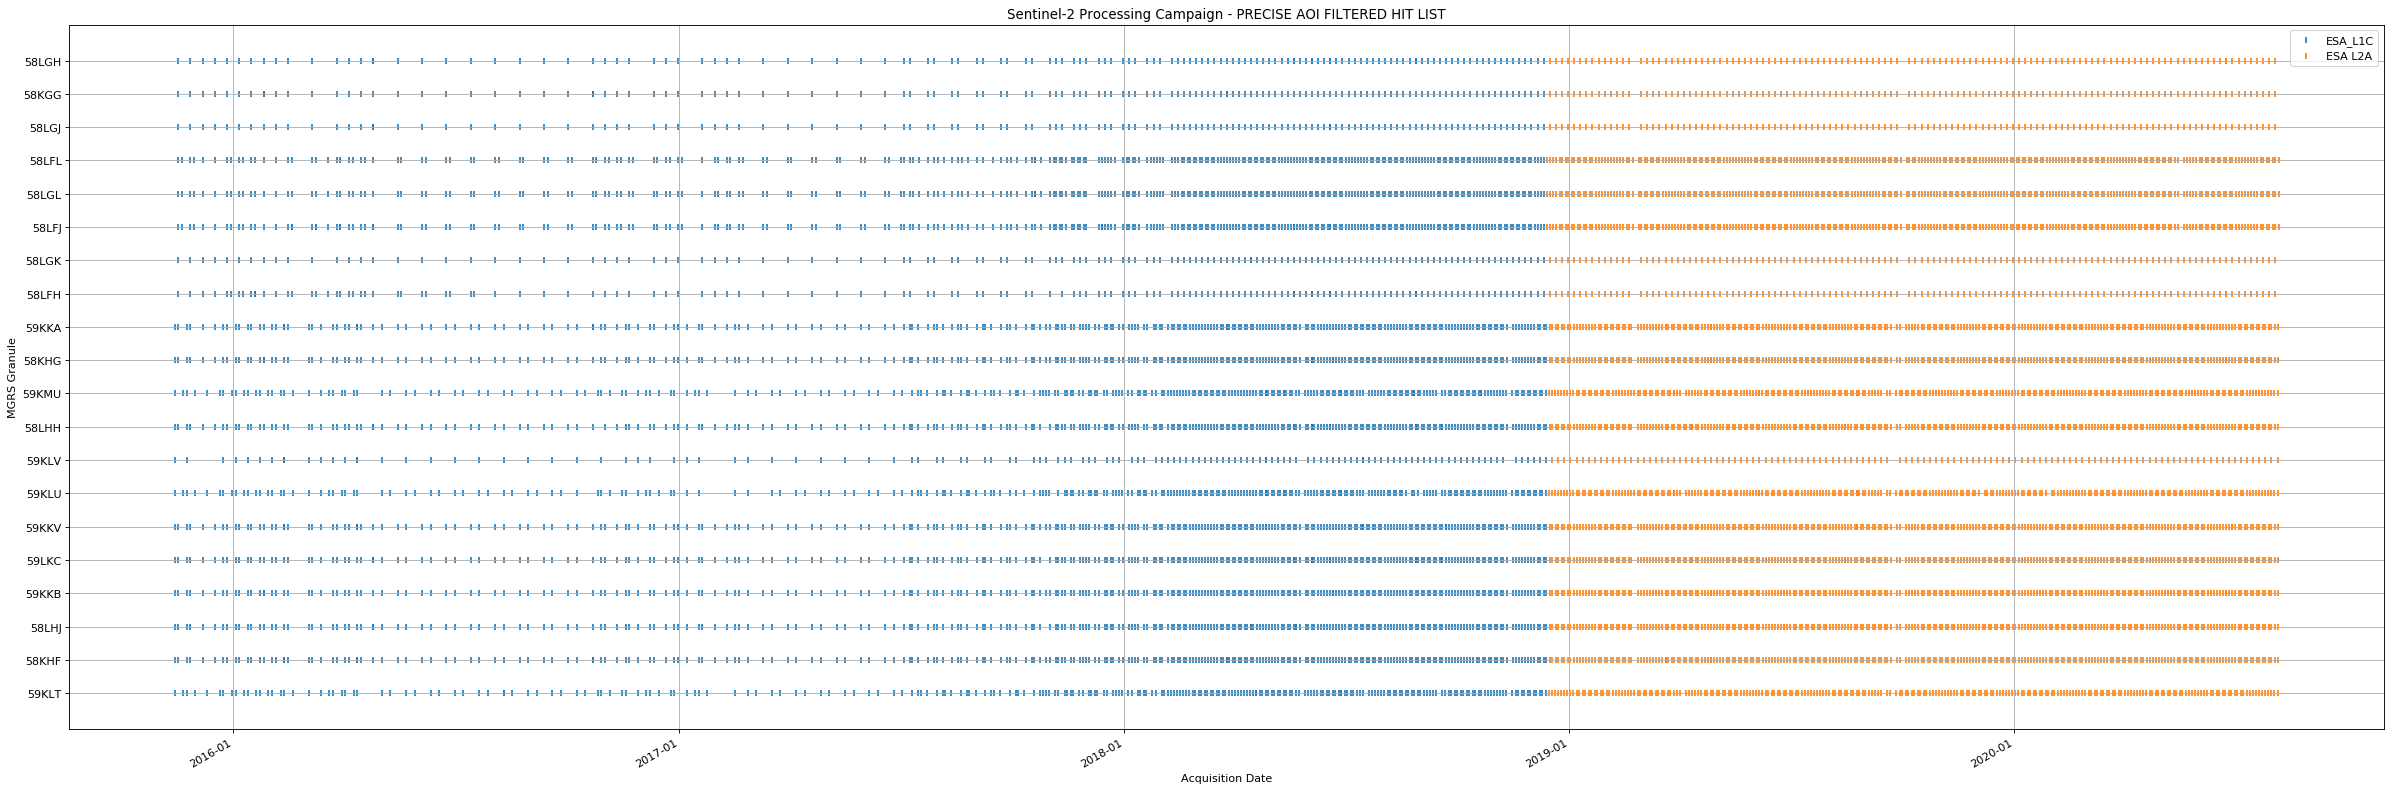

In [55]:
# Plot temporality of L1C and L2A
fig, ax = plt.subplots(figsize=(30,10),dpi=80)
fig.autofmt_xdate()

df = esa_l1c_precise
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%d', utc=True)
#df = df[(df['Acquisition Date']>datetime.date(2019,1,1)) & (df['Acquisition Date']<datetime.date(2020,1,1))]
ax.scatter(df['Acquisition Date'].values, df['granules'].values, marker='|');

df = esa_l2a_precise
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%d', utc=True)
#df = df[(df['Acquisition Date']>datetime.date(2019,1,1)) & (df['Acquisition Date']<datetime.date(2020,1,1))]
ax.scatter(df['Acquisition Date'].values, df['granules'].values, marker='|');

# df = gc_l1c_match
# df['Acquisition Date'] = pd.to_datetime(df['SENSING_TIME'], format='%Y-%m-%d', utc=True)
# df['granules'] = df['MGRS_TILE']
# # remove files showing as NaN size
# df = df.dropna(subset=['TOTAL_SIZE'])
# #df = df[(df['Acquisition Date']>datetime.date(2019,1,1)) & (df['Acquisition Date']<datetime.date(2020,1,1))]
# ax.scatter(df['Acquisition Date'].values, df['granules'].values, marker='_');

# df = gc_l2a_match
# df['Acquisition Date'] = pd.to_datetime(df['SENSING_TIME'], format='%Y-%m-%d', utc=True)
# df['granules'] = df['MGRS_TILE']
# # remove files showing as NaN size
# df = df.dropna(subset=['TOTAL_SIZE'])
# #df = df[(df['Acquisition Date']>datetime.date(2019,1,1)) & (df['Acquisition Date']<datetime.date(2020,1,1))]
# ax.scatter(df['Acquisition Date'].values, df['granules'].values, marker='|');

ax.set_ylabel('MGRS Granule');
ax.set_xlabel("Acquisition Date");
ax.legend(['ESA_L1C','ESA L2A','USGS_L4-5TM','USGS_L1-4MSS']);
ax.set_title("Sentinel-2 Processing Campaign - PRECISE AOI FILTERED HIT LIST");
ax.xaxis.set_major_locator(mdates.AutoDateLocator());
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m") ); 
ax.grid(which='both')
fig.tight_layout()
#fig.savefig('../Search_Discovery/Fiji_S1_tempdistribution_orbitdirection');

### CROSS-CHECK AGAINST S3 BUCKET

In [77]:
s3_bucket = 'public-eo-data'
s3_dir = f'common_sensing/{region_bucket_name}/sentinel_2/'

In [78]:
paths_sizes = s3_list_objects_pathssize(s3_bucket, s3_dir)

In [79]:
bucket_df = pd.DataFrame(paths_sizes, columns=['path','size'])
bucket_df['scenename'] = bucket_df.path.apply(lambda x: x.split('/')[3])

bucket_df_scns = bucket_df.groupby('scenename').sum()
bucket_df_scns['scenename'] = bucket_df_scns.index

In [80]:
# s3_paths = s3_list_objects_paths(s3_bucket, s3_dir)
s3_paths = bucket_df.path.values
yamls = [i for i in s3_paths if i.split('/')[-1][-4:] == 'yaml']

In [81]:
s3_nms = [i.split('/')[-2] for i in yamls]
esa_l2_nms = [i.replace('MSIL1C','MSIL2A') for i in esa_l2a_precise.scenename.values]
esa_l2a_precise['SAC_DONE'] = [ i in s3_nms for i in esa_l2_nms]
esa_l1_nms = [i.replace('MSIL1C','MSIL2A') for i in esa_l1c_precise.scenename.values]
esa_l1c_precise['SAC_DONE'] = [ i in s3_nms for i in esa_l1_nms]

esa_l2a_precise['SAC_DONE'].value_counts(), esa_l1c_precise['SAC_DONE'].value_counts()

(True     3336
 False     717
 Name: SAC_DONE, dtype: int64,
 True     2692
 False    1683
 Name: SAC_DONE, dtype: int64)

In [61]:
esa_l2a_precise['SAC_SIZE'] = [ bucket_df_scns[bucket_df_scns.scenename == i.replace('MSIL1C','MSIL2A')]['size'].values[0] if i.replace('MSIL1C','MSIL2A') in bucket_df_scns.scenename.values else np.NaN for i in esa_l2a_precise.scenename.values  ]

In [62]:
esa_l1c_precise['SAC_SIZE'] = [ bucket_df_scns[bucket_df_scns.scenename == i.replace('MSIL1C','MSIL2A')]['size'].values[0] if i.replace('MSIL1C','MSIL2A') in bucket_df_scns.scenename.values else np.NaN for i in esa_l1c_precise.scenename.values  ]

In [63]:
esa_l2a_precise['SAC_SIZE'].sum(), esa_l1c_precise['SAC_SIZE'].sum()

(2475055729699.0, 1968624453340.0)

### CROSS-CHECK ESA AGAINST GCLOUD

In [64]:
esa_l1c_precise['GCLOUD_PRES'] = [i in gc_l1c_match.scenename.values  for i in esa_l1c_precise.scenename.values]
esa_l2a_precise['GCLOUD_PRES'] = [i in gc_l2a_match.scenename.values  for i in esa_l2a_precise.scenename.values]

esa_l2a_precise['GCLOUD_PRES'].value_counts(), esa_l1c_precise['GCLOUD_PRES'].value_counts()

(True     4031
 False      22
 Name: GCLOUD_PRES, dtype: int64,
 True     4285
 False      90
 Name: GCLOUD_PRES, dtype: int64)

In [65]:
# esa_l1c_precise['ESA_ONLINE'] = [ esa_api.get_product_odata(i)['Online'] for i in tqdm(esa_l1c_precise.uuid.values) ]
# esa_l2a_precise['ESA_ONLINE'] = [ esa_api.get_product_odata(i)['Online'] for i in tqdm(esa_l2a_precise.uuid.values) ]
# esa_l2a_precise['ESA_ONLINE'].value_counts(), esa_l1c_precise['ESA_ONLINE'].value_counts()

### SPLIT INTO APPROX SEN2COR VERSIONS
Using processing baseline as proxy for PD version, as cannot find a more robust means of differentiating pre/post 14.2

In [69]:
esa_l1c_precise_v5 = esa_l1c_precise[esa_l1c_precise.processingbaseline.isin(['02.01', '02.02', '02.04', '02.05'])]
esa_l1c_precise_v8 = esa_l1c_precise[~esa_l1c_precise.processingbaseline.isin(['02.01', '02.02', '02.04', '02.05'])]

### SAVE DFS

In [70]:
td = datetime.today()
td = td.strftime('%Y')+td.strftime('%m')+td.strftime('%d')
cols = ['title','scenename','cloudcoverpercentage','platformname','Acquisition Date','granules','SAC_DONE','SAC_SIZE','GCLOUD_PRES','uuid','geometry']

In [72]:
# save to L1 & L2 csvs
esa_l2a_precise[cols].to_csv(f"{inter_dir}outputs/SD_{td}_{region_name}_S2_L2A.csv")
esa_l1c_precise_v5[cols].to_csv(f"{inter_dir}outputs/SD_{td}_{region_name}_S2_L1Cv5.csv")
esa_l1c_precise_v8[cols].to_csv(f"{inter_dir}outputs/SD_{td}_{region_name}_S2_L1Cv8.csv")

### CREATE JOBLIST

In [73]:
to_do_l1_v5 = []
for s, p in zip(esa_l1c_precise_v5.title.values, esa_l1c_precise_v5.SAC_DONE):
    if not p:
        to_do_l1_v5.append(s)
print(len(to_do_l1_v5),to_do_l1_v5[0])
to_do_l1_v8 = []
for s, p in zip(esa_l1c_precise_v8.title.values, esa_l1c_precise_v8.SAC_DONE):
    if not p:
        to_do_l1_v8.append(s)
print(len(to_do_l1_v8),to_do_l1_v8[0])
to_do_l2 = []
for s, p in zip(esa_l2a_precise.title.values, esa_l2a_precise.SAC_DONE):
    if not p:
        to_do_l2.append(s)
print(len(to_do_l2),to_do_l2[0])

1651 S2A_MSIL1C_20171016T230911_N0205_R101_T58LGH_20171016T230905
32 S2A_MSIL1C_20180226T231851_N0206_R001_T58LFL_20180227T003950
717 S2A_MSIL2A_20200804T231901_N0214_R001_T58LGL_20200805T005001


In [76]:
with open(f"{inter_dir}outputs/JOBLIST_{td}_{region_name}_S2_L1Cv5.txt", 'a') as t:
    for v in to_do_l1_v5:
        t.write("rpush jobS2"+" '{"+'"in_scene": "'+ v +f'", "s3_bucket": "public-eo-data", "s3_dir": "common_sensing/{region_bucket_name}/sentinel_2/"'+"}'" + '\n')

with open(f"{inter_dir}outputs/JOBLIST_{td}_{region_name}_S2_L1Cv8.txt", 'a') as t:
    for v in to_do_l1_v8:
        t.write("rpush jobS2"+" '{"+'"in_scene": "'+ v +f'", "s3_bucket": "public-eo-data", "s3_dir": "common_sensing/{region_bucket_name}/sentinel_2/"'+"}'" + '\n')

with open(f"{inter_dir}outputs/JOBLIST_{td}_{region_name}_S2_L2A.txt", 'a') as t:
    for v in to_do_l2:
        t.write("rpush jobS2"+" '{"+'"in_scene": "'+ v +f'", "s3_bucket": "public-eo-data", "s3_dir": "common_sensing/{region_bucket_name}/sentinel_2/"'+"}'" + '\n')

# **SENTINEL-1**

## ESA QUERY

In [82]:
# Login to esa api
esa_api = SentinelAPI(os.environ['COPERNICUS_USERNAME'],os.environ['COPERNICUS_PWD'])

In [83]:
# ESA Query
res = esa_api.query(aoi_wkt,platformname='Sentinel-1',producttype='GRD',sensoroperationalmode='IW')
esa_grd = esa_api.to_geodataframe(res)

Querying products: 100%|██████████| 1122/1122 [00:21<00:00, 53.19 products/s]


## ASF QUERY

In [84]:
asf_grd_matches = get_s1_asf_urls(esa_grd.title.values)

In [85]:
df = pd.merge(left=esa_grd, right=asf_grd_matches, how='left', left_on='title', right_on='Granule Name')

In [111]:
# Create bool for intersection between any tiles 
for n, g in zip(aoi.NAME, aoi.geometry):
    df[n] = df.geometry.apply(lambda x: gpd.GeoSeries(x).intersects(g))
# Filter based on any True intersections
df[region_name] = df[df[aoi.NAME.values]].any(1)
df_c = df[df[region_name]==True]

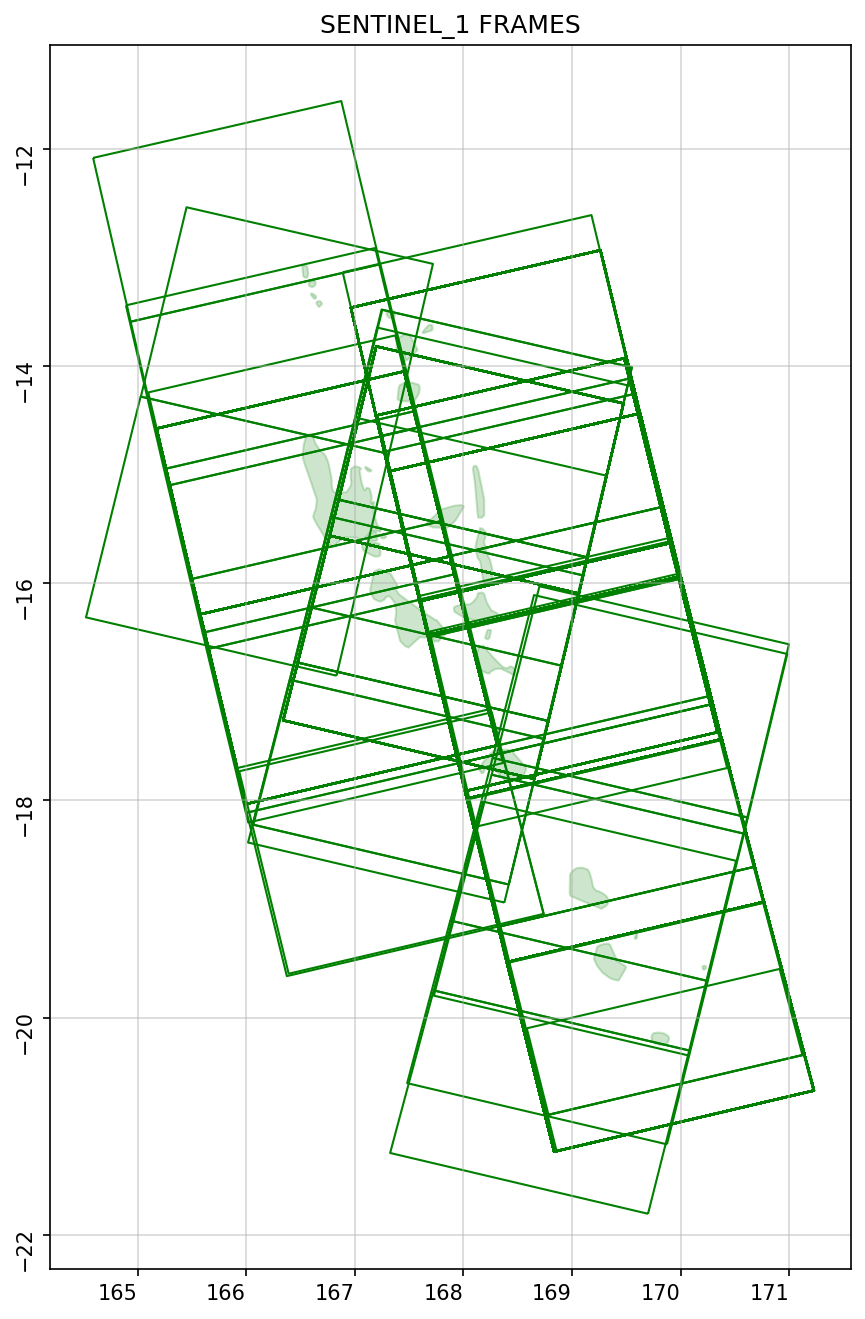

In [112]:
# Plot coverage
fig, ax = plt.subplots(figsize=(12,12),dpi=150)
fig.autofmt_xdate()
leg_patches=[]

x = aoi.to_crs(plot_crs).plot(facecolor="g", edgecolor='g', ax=ax, alpha=0.2);
leg_patches.append(mpatches.Patch(facecolor="g", edgecolor='g', alpha=0.25, lw=0.7, label=region_name))

df_c.to_crs(plot_crs).plot(facecolor='',edgecolor='g',ax=ax)

ax.set_title('SENTINEL_1 FRAMES')
ax.grid(alpha=0.5);
ax.tick_params(axis='y', rotation=90);
ax.tick_params(axis='x', rotation=0);

## ADDRESS ANTI_MERIDIAN NON-OVERLAP
For Fiji need to un-comment appropriate cells below. nb: should be possible to inc. more robust non-AM test so don't need to do this.

In [113]:
# plot_crs = {"init": "epsg:3460"}

# # select scenes over mainisland for product development
# non_am = "POLYGON((177.07301550947307 -17.17940113068343,177.72120886884807 -17.17940113068343,177.72120886884807 -18.689732935559707,177.07301550947307 -18.689732935559707,177.07301550947307 -17.17940113068343))"
# non_am = pd.DataFrame(data={'geometry': [non_am]})
# non_am['geometry'] = non_am['geometry'].apply(wkt.loads)
# non_am['NAME'] = 'SUB'
# non_am = gpd.GeoDataFrame(non_am, geometry='geometry', crs=('epsg:4326'))
# non_am.crs = from_epsg(4326)

# # intersect non-am subset
# non_am_fij = non_am.to_crs({"init": "epsg:3460"})
# df_c['des'] = df_c.to_crs({"init": "epsg:3460"}).geometry.map(lambda x: x.intersects(non_am_fij.geometry.any())) # repro and test intersect
# df_c_nonam = df_c[df_c['des']==True] # subset



# # Plot coverage
# fig, ax = plt.subplots(figsize=(12,12),dpi=150)
# fig.autofmt_xdate()
# leg_patches=[]

# x = aoi.to_crs(plot_crs).plot(facecolor="g", edgecolor='g', ax=ax, alpha=0.2);
# leg_patches.append(mpatches.Patch(facecolor="g", edgecolor='g', alpha=0.25, lw=0.7, label=region_name))

# df_c.to_crs(plot_crs).plot(facecolor='',edgecolor='b',ax=ax)

# df_c_nonam.to_crs(plot_crs).plot(facecolor='',edgecolor='orange',ax=ax)

# non_am.to_crs(plot_crs).plot(facecolor='',edgecolor='r',ax=ax)

# ax.set_title('SENTINEL_1 FRAMES')
# ax.grid(alpha=0.5);
# ax.tick_params(axis='y', rotation=90);
# ax.tick_params(axis='x', rotation=0);

In [114]:
df_c_nonam = df_c

In [115]:
# df_c_am = df_c[~df_c.title.isin(df_c_nonam.title) ]

## CROSS-CHECK AGAINST S3 BUCKET

In [116]:
s3_bucket = 'public-eo-data'
s3_dir = f'common_sensing/{region_bucket_name}/sentinel_1/'

In [117]:
paths_sizes = s3_list_objects_pathssize(s3_bucket, s3_dir)

In [118]:
bucket_df = pd.DataFrame(paths_sizes, columns=['path','size'])
bucket_df['scenename'] = bucket_df.path.apply(lambda x: x.split('/')[3])

bucket_df_scns = bucket_df.groupby('scenename').sum()
bucket_df_scns['scenename'] = bucket_df_scns.index

In [119]:
# s3_paths = s3_list_objects_paths(s3_bucket, s3_dir)
s3_paths = bucket_df.path.values
yamls = [i for i in s3_paths if i.split('/')[-1][-4:] == 'yaml']

In [120]:
df_c_nonam['SAC_DONE'] = [ i[:32] in [j.split('/')[-2] for j in yamls] for i in df_c_nonam.title.values ]
df_c_nonam['scenename'] = [ i[:32] for i in df_c_nonam.title.values ]
df_c_nonam['SAC_SIZE'] = [ bucket_df_scns[bucket_df_scns.scenename == i ]['size'].values[0] if i in bucket_df_scns.scenename.values else np.NaN for i in df_c_nonam.scenename.values  ]

In [123]:
df_c_nonam['SAC_DONE'].value_counts()

True     782
False    100
Name: SAC_DONE, dtype: int64

In [124]:
# df_c_am['SAC_DONE'] = [ i[:32] in [j.split('/')[-2] for j in yamls] for i in df_c_am.title.values ]
# df_c_am['scenename'] = [ i[:32] for i in df_c_am.title.values ]
# df_c_am['SAC_SIZE'] = [ bucket_df_scns[bucket_df_scns.scenename == i ]['size'].values[0] if i in bucket_df_scns.scenename.values else np.NaN for i in df_c_am.scenename.values  ]

In [127]:
# df_c_am['SAC_DONE'].value_counts()

In [128]:
td = datetime.today()
td = td.strftime('%Y')+td.strftime('%m')+td.strftime('%d')

In [129]:
# save to L1 & L2 csvs
df_c_nonam.to_csv(f"{inter_dir}outputs/SD_{td}_{region_name}_S1_GRD_nonAM.csv")

In [110]:
# df_c_am.to_csv(f"{inter_dir}outputs/SD_{td}_{region_name}_S1_GRD_AM.csv")

### CREATE JOBLIST
Only done nonAM so far

In [130]:
to_do = []
for s, p in zip(df_c_nonam.title.values, df_c_nonam.SAC_DONE):
    if not p:
        to_do.append(s)
len(to_do),to_do[0]

(100, 'S1A_IW_GRDH_1SDV_20200804T071426_20200804T071451_033753_03E989_2A68')

In [132]:
dems = {
    'Fiji':            'common_sensing/ancillary_products/SRTM1Sec/SRTM30_Fiji_E.tif',
    'Solomon Islands': 'common_sensing/ancillary_products/SRTM1Sec/SolomonIslands_DEM.tif',
    'Vanuatu':         'common_sensing/ancillary_products/SRTM1Sec/Vanuatu_DEM.tif'
}

In [136]:
with open(f"{inter_dir}outputs/JOBLIST_{td}_{region_name}_S1_nonAM.txt", 'w') as t:
    
    for v in to_do:

        t.write("rpush jobS1"+" '{"+'"in_scene": "'+ v +f'", "s3_bucket": "public-eo-data", "s3_dir": "common_sensing/{region_bucket_name}/sentinel_1/", "ext_dem": "{dems[region_name]}"'+"}'" + '\n')

# **LANDSAT**

### Check intersecting tiles

In [137]:
# load world granules
world_granules = gpd.read_file(anc_paths['lstiles_path'][0])
# Create bool for intersection between any tiles - should try inversion to speed up...
for n, g in zip(aoi.NAME, aoi.geometry):
    world_granules[n] = world_granules.geometry.apply(lambda x: gpd.GeoSeries(x).intersects(g))
# Filter based on any True intersections
world_granules[region_name] = world_granules[world_granules[aoi.NAME.values]].any(1)
region_ls_grans = world_granules[world_granules[region_name]==True]

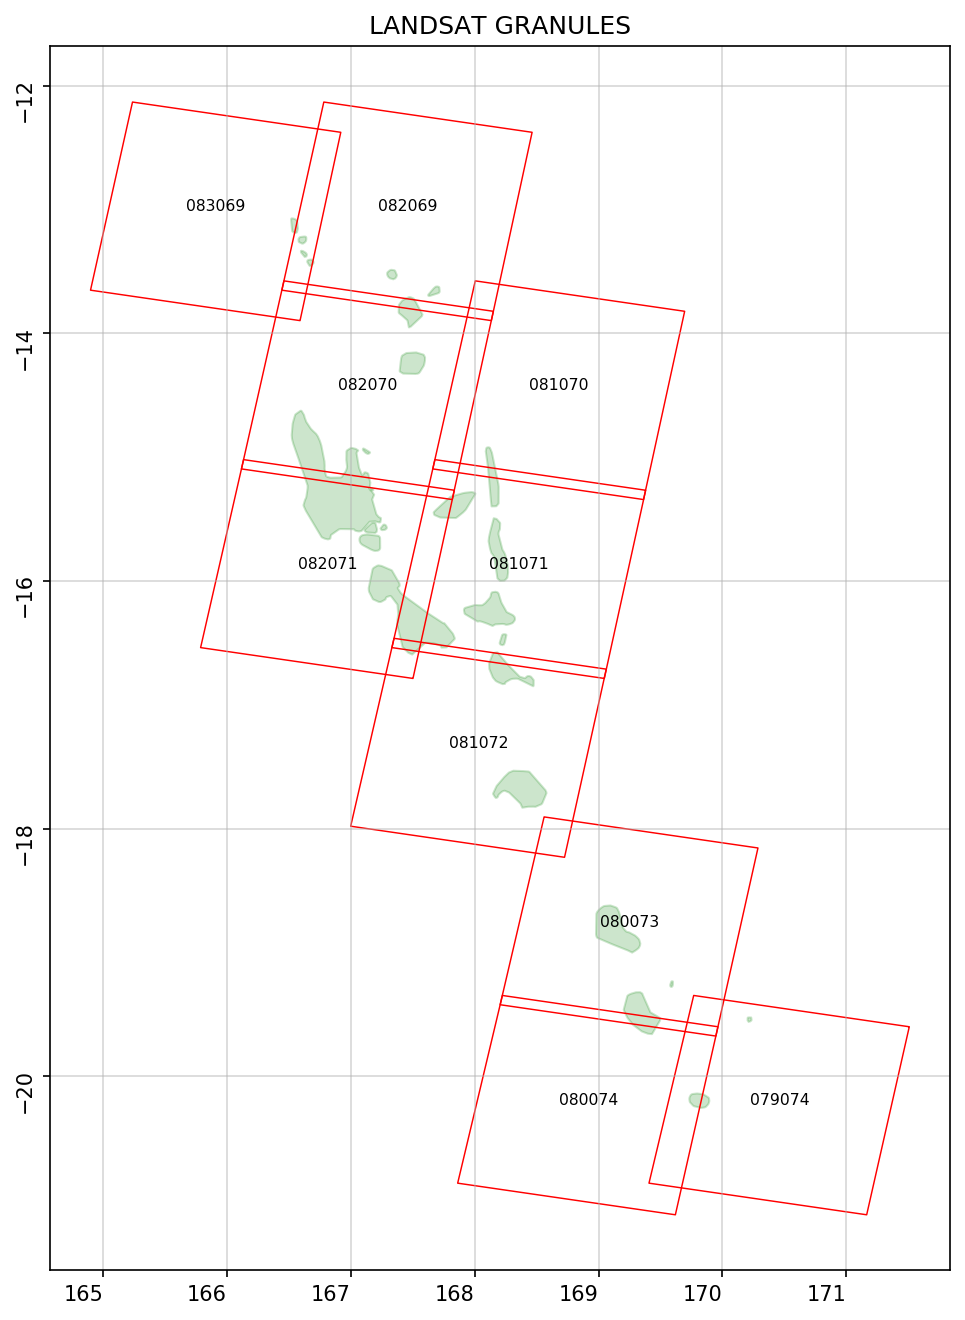

In [138]:
# Plot coverage
fig, ax = plt.subplots(figsize=(12,12),dpi=150)
fig.autofmt_xdate()
leg_patches=[]

x = aoi.to_crs(plot_crs).plot(facecolor="g", edgecolor='g', ax=ax, alpha=0.2);
leg_patches.append(mpatches.Patch(facecolor="g", edgecolor='g', alpha=0.25, lw=0.7, label=region_name))

x = region_ls_grans.to_crs(plot_crs).plot(facecolor="none", edgecolor='r', lw=0.7, ax=ax)
leg_patches.append(mpatches.Patch(facecolor="none", edgecolor='r', lw=0.7, label='Sentinel-2 Tiles'))
region_ls_grans.to_crs(plot_crs).apply(lambda x: ax.annotate(s=x.PR, xy=x.geometry.centroid.coords[0], ha='center', fontsize=7.5),axis=1)

ax.set_title('LANDSAT GRANULES')
ax.grid(alpha=0.5);
ax.tick_params(axis='y', rotation=90);
ax.tick_params(axis='x', rotation=0);

### For each LS sensor check acquisition csvs for availability of the intersecting tiles

In [139]:
pr = region_ls_grans
df = pd.read_csv(anc_paths['ls8csv_path'][0]) # latest csv can be found at - https://www.usgs.gov/land-resources/nli/landsat/bulk-metadata-service
df = df[df.row.isin(pr.ROW.values)&df.path.isin(pr.PATH.values)]
res3 = df
df = None

In [141]:
s3_bucket = 'public-eo-data'
s3_dir = f'common_sensing/{region_bucket_name}/landsat_8/'

In [142]:
paths_sizes = s3_list_objects_pathssize(s3_bucket, s3_dir)

In [143]:
bucket_df = pd.DataFrame(paths_sizes, columns=['path','size'])
bucket_df['scenename'] = bucket_df.path.apply(lambda x: x.split('/')[3])

bucket_df_scns = bucket_df.groupby('scenename').sum()
bucket_df_scns['scenename'] = bucket_df_scns.index

In [144]:
# s3_paths = s3_list_objects_paths(s3_bucket, s3_dir)
s3_paths = bucket_df.path.values
yamls = [i for i in s3_paths if i.split('/')[-1][-4:] == 'yaml']

In [145]:
res3['scenename'] = [ i[:25].replace('L1GT','L1TP') for i in res3.LANDSAT_PRODUCT_ID.values ]

In [146]:
res3['SAC_DONE'] = [ i in [j.split('/')[-2] for j in yamls] for i in res3.scenename.values ]

In [147]:
res3['SAC_SIZE'] = [ bucket_df_scns[bucket_df_scns.scenename == i ]['size'].values[0] if i in bucket_df_scns.scenename.values else np.NaN for i in res3.scenename.values  ]

In [148]:
res3['SAC_DONE'].value_counts()

True     2319
False     127
Name: SAC_DONE, dtype: int64

In [149]:
df = pd.read_csv(anc_paths['ls7csv_path'][0]) # latest csv can be found at - https://www.usgs.gov/land-resources/nli/landsat/bulk-metadata-service
df = df[df.row.isin(pr.ROW.values)&df.path.isin(pr.PATH.values)]
res2 = df
df = None

In [150]:
s3_bucket = 'public-eo-data'
s3_dir = f'common_sensing/{region_bucket_name}/landsat_7/'

In [151]:
paths_sizes = s3_list_objects_pathssize(s3_bucket, s3_dir)

In [152]:
bucket_df = pd.DataFrame(paths_sizes, columns=['path','size'])
bucket_df['scenename'] = bucket_df.path.apply(lambda x: x.split('/')[3])

bucket_df_scns = bucket_df.groupby('scenename').sum()
bucket_df_scns['scenename'] = bucket_df_scns.index

In [153]:
# s3_paths = s3_list_objects_paths(s3_bucket, s3_dir)
s3_paths = bucket_df.path.values
yamls = [i for i in s3_paths if i.split('/')[-1][-4:] == 'yaml']

In [154]:
res2['scenename'] = [ i[:25].replace('L1GT','L1TP') for i in res2.LANDSAT_PRODUCT_ID.values ]

In [155]:
res2['SAC_DONE'] = [ i in [j.split('/')[-2] for j in yamls] for i in res2.scenename.values ]

In [156]:
res2['SAC_SIZE'] = [ bucket_df_scns[bucket_df_scns.scenename == i ]['size'].values[0] if i in bucket_df_scns.scenename.values else np.NaN for i in res2.scenename.values  ]

In [157]:
res2['SAC_DONE'].value_counts()

True    861
Name: SAC_DONE, dtype: int64

In [158]:
# pr = country_ls_grans
df = pd.read_csv(anc_paths['ls45csv_path'][0]) # latest csv can be found at - https://www.usgs.gov/land-resources/nli/landsat/bulk-metadata-service
df = df[df.row.isin(pr.ROW.values)&df.path.isin(pr.PATH.values)]
res1 = df
df = None

In [159]:
s3_bucket = 'public-eo-data'
s3_dir = f'common_sensing/{region_bucket_name}/landsat_4/'

In [160]:
paths_sizes = s3_list_objects_pathssize(s3_bucket, f'common_sensing/{region_bucket_name}/landsat_4/') + s3_list_objects_pathssize(s3_bucket, f'common_sensing/{region_bucket_name}/landsat_5/')

In [161]:
bucket_df = pd.DataFrame(paths_sizes, columns=['path','size'])
bucket_df['scenename'] = bucket_df.path.apply(lambda x: x.split('/')[3])

bucket_df_scns = bucket_df.groupby('scenename').sum()
bucket_df_scns['scenename'] = bucket_df_scns.index

In [162]:
# s3_paths = s3_list_objects_paths(s3_bucket, s3_dir)
s3_paths = bucket_df.path.values
yamls = [i for i in s3_paths if i.split('/')[-1][-4:] == 'yaml']

In [163]:
res1['scenename'] = [ i[:25].replace('L1GS','L1TP') for i in res1.LANDSAT_PRODUCT_ID.values ]

In [164]:
res1['SAC_DONE'] = [ i in [j.split('/')[-2] for j in yamls] for i in res1.scenename.values ]

In [165]:
res1['SAC_SIZE'] = [ bucket_df_scns[bucket_df_scns.scenename == i ]['size'].values[0] if i in bucket_df_scns.scenename.values else np.NaN for i in res1.scenename.values  ]

In [166]:
res1['SAC_DONE'].value_counts()

True     124
False     14
Name: SAC_DONE, dtype: int64

### Save df

In [168]:
td = datetime.today()
td = td.strftime('%Y')+td.strftime('%m')+td.strftime('%d')

In [169]:
# save to L1 & L2 csvs
res1.to_csv(f"{inter_dir}outputs/SD_{td}_{region_name}_LS_TM.csv")
res2.to_csv(f"{inter_dir}outputs/SD_{td}_{region_name}_LS_ETM.csv")
res3.to_csv(f"{inter_dir}outputs/SD_{td}_{region_name}_LS_OLI.csv")

### Filter dfs to those ids to be ordered

In [196]:
ls_oli = pd.read_csv(glob.glob(f"{inter_dir}outputs/SD_*_{region_name}_LS_OLI.csv")[0])
ls_oli = ls_oli[~ls_oli.SAC_DONE]
ls_oli

,Unnamed: 0,PANCHROMATIC_LINES,NADIR_OFFNADIR,sunAzimuth,REFLECTIVE_SAMPLES,upperLeftCornerLongitude,cloudCover,MAP_PROJECTION_L1,cartURL,sunElevation,...,DATUM,COLLECTION_NUMBER,sceneID,RLUT_FILE_NAME,TIRS_SSM_MODEL,ROLL_ANGLE,receivingStation,scenename,SAC_DONE,SAC_SIZE
0,457,15421,NADIR,39.643674,7601,168.58353,21.02,UTM,https://earthexplorer.usgs.gov/download/extern...,40.190096,...,WGS84,1,LC80800732020202LGN00,LC08RLUT_20150303_20431231_01_12.h5,PRELIMINARY,0.000,LGN,LC08_L1TP_080073_20200720,False,NaN
1,458,15401,NADIR,39.106146,7591,168.24464,34.99,UTM,https://earthexplorer.usgs.gov/download/extern...,38.935254,...,WGS84,1,LC80800742020202LGN00,LC08RLUT_20150303_20431231_01_12.h5,PRELIMINARY,-0.001,LGN,LC08_L1TP_080074_20200720,False,NaN
2,1996,15601,NADIR,41.892363,7671,166.80716,23.14,UTM,https://earthexplorer.usgs.gov/download/extern...,44.867204,...,WGS84,1,LC80820692020200LGN00,LC08RLUT_20150303_20431231_01_12.h5,PRELIMINARY,-0.001,LGN,LC08_L1TP_082069_20200718,False,NaN
3,1997,15581,NADIR,41.167436,7681,166.48370,87.91,UTM,https://earthexplorer.usgs.gov/download/extern...,43.644224,...,WGS84,1,LC80820702020200LGN00,LC08RLUT_20150303_20431231_01_12.h5,PRELIMINARY,-0.001,LGN,LC08_L1TP_082070_20200718,False,NaN
4,1998,15601,NADIR,40.496436,7671,166.15688,71.48,UTM,https://earthexplorer.usgs.gov/download/extern...,42.410935,...,WGS84,1,LC80820712020200LGN00,LC08RLUT_20150303_20431231_01_12.h5,PRELIMINARY,-0.001,LGN,LC08_L1TP_082071_20200718,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2294,1638834,15661,NADIR,73.718359,7731,167.39516,97.01,UTM,https://earthexplorer.usgs.gov/download/extern...,56.520084,...,WGS84,1,LO80810722014064LGN01,LC08RLUT_20130211_20150302_01_11.h5,NaN,-0.001,LGN,LO08_L1TP_081072_20140305,False,NaN
2295,1638835,15681,NADIR,71.826055,7731,167.06205,71.38,UTM,https://earthexplorer.usgs.gov/download/extern...,55.885335,...,WGS84,1,LO80810732014064LGN01,LC08RLUT_20130211_20150302_01_11.h5,NaN,-0.001,LGN,LO08_L1TP_081073_20140305,False,NaN
2296,1638876,15421,NADIR,77.758724,7581,168.04977,99.93,UTM,https://earthexplorer.usgs.gov/download/extern...,57.648735,...,WGS84,1,LO80810702014064LGN01,LC08RLUT_20130211_20150302_01_11.h5,NaN,-0.001,LGN,LO08_L1TP_081070_20140305,False,NaN
2297,1638905,15381,NADIR,75.697193,7571,167.72437,92.65,UTM,https://earthexplorer.usgs.gov/download/extern...,57.108904,...,WGS84,1,LO80810712014064LGN01,LC08RLUT_20130211_20150302_01_11.h5,NaN,-0.001,LGN,LO08_L1TP_081071_20140305,False,NaN


In [197]:
ls_etm = pd.read_csv(glob.glob(f"{inter_dir}outputs/SD_*_{region_name}_LS_ETM.csv")[0])
ls_etm = ls_etm[~ls_etm.SAC_DONE]
ls_etm

,Unnamed: 0,PANCHROMATIC_LINES,THERMAL_LINES,SCAN_GAP_INTERPOLATION,sunAzimuth,REFLECTIVE_SAMPLES,upperRightCornerLatitude,cloudCover,MAP_PROJECTION_L1,cartURL,...,UTM_ZONE,DATE_L1_GENERATED,GRID_CELL_SIZE_THERMAL,DATUM,COLLECTION_NUMBER,sceneID,receivingStation,scenename,SAC_DONE,SAC_SIZE


In [199]:
ls_tm = pd.read_csv(glob.glob(f"{inter_dir}outputs/SD_*_{region_name}_LS_TM.csv")[0])
ls_tm = ls_tm[~ls_tm.SAC_DONE]
ls_tm

,Unnamed: 0,THERMAL_LINES,sunAzimuth,REFLECTIVE_SAMPLES,upperRightCornerLatitude,cloudCover,MAP_PROJECTION_L1,cartURL,sunElevation,path,...,UTM_ZONE,DATE_L1_GENERATED,GRID_CELL_SIZE_THERMAL,DATUM,COLLECTION_NUMBER,sceneID,receivingStation,scenename,SAC_DONE,SAC_SIZE
0,2290396,6941,67.823981,7761,-16.66971,79,UTM,https://earthexplorer.usgs.gov/download/extern...,48.425236,80,...,59.0,2017/01/28,30,WGS84,1,LT50800721990263XXX01,XXX,LT05_L1TP_080072_19900920,False,320218587
1,2290397,6931,66.519755,7761,-18.10134,76,UTM,https://earthexplorer.usgs.gov/download/extern...,47.672186,80,...,59.0,2017/01/28,30,WGS84,1,LT50800731990263XXX03,XXX,LT05_L1TP_080073_19900920,False,363644943
2,2290398,6931,65.257774,7751,-19.55844,85,UTM,https://earthexplorer.usgs.gov/download/extern...,46.875158,80,...,59.0,2017/01/30,30,WGS84,1,LT50800741990263XXX03,XXX,LT05_L1TP_080074_19900920,False,356833085
3,2290918,7011,71.140362,7831,-12.33400,77,UTM,https://earthexplorer.usgs.gov/download/extern...,50.061606,82,...,58.0,2017/01/30,30,WGS84,1,LT50820691990261XXX04,XXX,LT05_L1TP_082069_19900918,False,333972485
4,2290919,7021,69.685043,7831,-13.76697,63,UTM,https://earthexplorer.usgs.gov/download/extern...,49.379714,82,...,58.0,2017/01/29,30,WGS84,1,LT50820701990261XXX04,XXX,LT05_L1TP_082070_19900918,False,329237926
6,2290921,7011,66.930167,7841,-16.66636,92,UTM,https://earthexplorer.usgs.gov/download/extern...,47.906626,82,...,58.0,2017/01/28,30,WGS84,1,LT50820721990261XXX01,XXX,LT05_L1TP_082072_19900918,False,343925410
8,2292742,6971,62.456337,7801,-19.55313,81,UTM,https://earthexplorer.usgs.gov/download/extern...,44.906524,79,...,59.0,2017/01/28,30,WGS84,1,LT50790741990256XXX03,XXX,LT05_L1TP_079074_19900913,False,318711749
9,2293564,6911,65.151343,7741,-15.21374,100,UTM,https://earthexplorer.usgs.gov/download/extern...,46.869240,81,...,59.0,2017/01/28,30,WGS84,1,LT50810711990254XXX01,XXX,LT05_L1TP_081071_19900911,False,268715936
10,2293565,7061,63.932028,7891,-16.67165,100,UTM,https://earthexplorer.usgs.gov/download/extern...,46.044646,81,...,58.0,2017/01/28,30,WGS84,1,LT50810721990254XXX03,XXX,LT05_L1TP_081072_19900911,False,276968042
11,2293566,7071,62.793595,7891,-18.10303,66,UTM,https://earthexplorer.usgs.gov/download/extern...,45.211672,81,...,58.0,2017/01/28,30,WGS84,1,LT50810731990254XXX01,XXX,LT05_L1TP_081073_19900911,False,260440248


### Actually placing order done manually for each sensor

Get prod IDs

In [200]:
# l8_list = list(ls_oli.LANDSAT_PRODUCT_ID.values)
l8_list = list(ls_tm.LANDSAT_PRODUCT_ID.values)

sign into espa

In [183]:
# function for basic interaction with ESPA API - hacked together from their 'how to page'
def espa_api(endpoint, verb='get', body=None, uauth=None):
    """ Suggested simple way to interact with the ESPA JSON REST API """
    auth_tup = uauth if uauth else (username, password)
    response = getattr(requests, verb)(host + endpoint, auth=auth_tup, json=body)
    print('{} {}'.format(response.status_code, response.reason))
    data = response.json()
    if isinstance(data, dict):
        messages = data.pop("messages", None)  
        if messages:
            print(json.dumps(messages, indent=4))
    try:
        response.raise_for_status()
    except Exception as e:
        print(e)
        return None
    else:
        return data

In [184]:
# earth explorer credentials are required
host = 'https://espa.cr.usgs.gov/api/v1/'
username = os.environ['USGS_USERNAME']
password = os.environ['USGS_PWD']
# check login
print('GET /api/v1/user')
resp = espa_api('user')
print(json.dumps(resp, indent=4))

GET /api/v1/user
200 OK
{
    "email": "tom.jones@sa.catapult.org.uk",
    "first_name": "Thomas",
    "last_name": "Jones",
    "roles": [
        "active"
    ],
    "username": "tom.jones"
}


In [195]:
## CHECK CONFLICTING ORDERS ###

# check for any existing orders that may prevent imediate processing of a fresh requestttttt
print('GET /api/v1/list-orders')
filters = {"status": ["complete", "ordered"]}  # Here, we ignore any purged orders
resp = espa_api('list-orders', body=filters)
print(json.dumps(resp, indent=4))

GET /api/v1/list-orders
200 OK
[
    "espa-tom.jones@sa.catapult.org.uk-08052020-084947-177"
]


In [201]:
### CHECK PRODUCT AVAILABILITY ###

# example of how to check available products for desired scenes
print('GET /api/v1/available-products')
avail_list = {'inputs': l8_list
             }
resp = espa_api('available-products', body=avail_list)
print(json.dumps(resp, indent=4))

GET /api/v1/available-products
200 OK
{
    "tm5_collection": {
        "products": [
            "source_metadata",
            "l1",
            "toa",
            "bt",
            "sr",
            "sr_ndvi",
            "sr_evi",
            "sr_savi",
            "sr_msavi",
            "sr_ndmi",
            "sr_nbr",
            "sr_nbr2",
            "stats",
            "pixel_qa",
            "et"
        ],
        "inputs": [
            "LT05_L1GS_080072_19900920_20170128_01_T2",
            "LT05_L1GS_080073_19900920_20170128_01_T2",
            "LT05_L1GS_080074_19900920_20170130_01_T2",
            "LT05_L1GS_082069_19900918_20170130_01_T2",
            "LT05_L1GS_082070_19900918_20170129_01_T2",
            "LT05_L1GS_082072_19900918_20170128_01_T2",
            "LT05_L1GS_079074_19900913_20170128_01_T2",
            "LT05_L1GS_081071_19900911_20170128_01_T2",
            "LT05_L1GS_081072_19900911_20170128_01_T2",
            "LT05_L1GS_081073_19900911_20170128_01_T2

In [188]:
# l8_list = list(ls_oli.LANDSAT_PRODUCT_ID.values)
# print(len(l8_list))
# er = set(["LC08_L1GT_072069_20160224_20170329_01_T2",
#             "LC08_L1GT_072071_20160224_20170329_01_T2",
#             "LC08_L1GT_072072_20160224_20170329_01_T2",
#             "LC08_L1TP_072073_20160224_20170329_01_T1",
#             "LC08_L1GT_072074_20160224_20170329_01_T2",
#             "LC08_L1GT_074069_20160222_20170329_01_T2",
#             "LC08_L1GT_074071_20160222_20170329_01_T2",
#             "LC08_L1TP_074072_20160222_20170329_01_T1",
#             "LC08_L1TP_074073_20160222_20170329_01_T1",
#             "LC08_L1TP_076069_20160220_20180202_01_T1"])
# #er = ['LC08_L1TP_166051_20190814_20190814_01_RT', 'LC08_L1TP_166048_20190814_20190814_01_RT']
# ls = l8_list
# #ls = [x (if x is not in er) for x in l8_list]
# for i in er: 
#     print(i)
#     ls.remove(er)
# print(len(ls))

In [202]:
### CREATE ORDER ###
# if any further subsetting is required. very recently acquired products are categorised as RT (as opposed to T1/T2). these are of insufficient certainty RE quality to be processed to ARD. this latency is unlikely to impact the non-NRT requirements of Common Sensing.
er = ['LC08_L1GT_072069_20160224_20170329_01_T2', 
      'LC08_L1GT_072071_20160224_20170329_01_T2', 
      'LC08_L1GT_072072_20160224_20170329_01_T2', 
      'LC08_L1TP_072073_20160224_20170329_01_T1', 
      'LC08_L1GT_072074_20160224_20170329_01_T2', 
      'LC08_L1GT_074069_20160222_20170329_01_T2', 
      'LC08_L1GT_074071_20160222_20170329_01_T2', 
      'LC08_L1TP_074072_20160222_20170329_01_T1', 
      'LC08_L1TP_074073_20160222_20170329_01_T1', 
      'LC08_L1TP_076069_20160220_20180202_01_T1'
     ]
#er = ['LC08_L1TP_166051_20190814_20190814_01_RT', 'LC08_L1TP_166048_20190814_20190814_01_RT']
l8_ls = [e for e in l8_list if e not in (er)]
l8_ls = [i for i in l8_list if 'RT' not in i]

# specifying differing products across the sensors
l8_prods = ["sr","bt","source_metadata","sr_ndvi","sr_evi","sr_savi","sr_msavi","sr_ndmi","sr_nbr","sr_nbr2","stats","pixel_qa"]
         
# determine available-products under their respective sensors
ls = l8_ls
print('GET /api/v1/available-products')
order = espa_api('available-products', body=dict(inputs=ls))
print(json.dumps(order, indent=4))

# replace available products with what we wish to process
for sensor in order.keys():
    if isinstance(order[sensor], dict) and order[sensor].get('inputs'):

        if set(l8_ls) & set(order[sensor]['inputs']):
            order[sensor]['products'] = l8_prods

# Add in the rest of the order information
#order['projection'] = projection
order['format'] = 'gtiff'
order['resampling_method'] = 'cc'
order['note'] = 'CS_WashUp_Vanuatu_TM'

# the order shoud now have changed from the original call available-products
print(json.dumps(order, indent=4))

GET /api/v1/available-products
200 OK
{
    "tm5_collection": {
        "products": [
            "source_metadata",
            "l1",
            "toa",
            "bt",
            "sr",
            "sr_ndvi",
            "sr_evi",
            "sr_savi",
            "sr_msavi",
            "sr_ndmi",
            "sr_nbr",
            "sr_nbr2",
            "stats",
            "pixel_qa",
            "et"
        ],
        "inputs": [
            "LT05_L1GS_080072_19900920_20170128_01_T2",
            "LT05_L1GS_080073_19900920_20170128_01_T2",
            "LT05_L1GS_080074_19900920_20170130_01_T2",
            "LT05_L1GS_082069_19900918_20170130_01_T2",
            "LT05_L1GS_082070_19900918_20170129_01_T2",
            "LT05_L1GS_082072_19900918_20170128_01_T2",
            "LT05_L1GS_079074_19900913_20170128_01_T2",
            "LT05_L1GS_081071_19900911_20170128_01_T2",
            "LT05_L1GS_081072_19900911_20170128_01_T2",
            "LT05_L1GS_081073_19900911_20170128_01_T2

In [193]:
order.keys()
# order.pop('date_restricted')
# order.pop('oli8_collection')

{'products': ['sr',
  'bt',
  'source_metadata',
  'sr_ndvi',
  'sr_evi',
  'sr_savi',
  'sr_msavi',
  'sr_ndmi',
  'sr_nbr',
  'sr_nbr2',
  'stats',
  'pixel_qa'],
 'inputs': ['LO08_L1TP_082069_20140328_20170424_01_T1',
  'LO08_L1TP_082070_20140328_20170424_01_T1',
  'LO08_L1GT_082071_20140328_20170424_01_T2',
  'LO08_L1TP_082074_20140328_20170424_01_T1',
  'LO08_L1GT_081069_20140305_20170425_01_T2',
  'LO08_L1GT_081072_20140305_20170425_01_T2',
  'LO08_L1GT_081073_20140305_20170425_01_T2',
  'LO08_L1GT_081070_20140305_20170425_01_T2',
  'LO08_L1GT_081071_20140305_20170425_01_T2',
  'LO08_L1TP_081074_20140305_20170425_01_T1']}

In [203]:
### PLACE ORDER ###
print('POST /api/v1/order')
resp = espa_api('order', verb='post', body=order)
print(resp.keys)
print(json.dumps(resp, indent=4))

POST /api/v1/order
201 CREATED
<built-in method keys of dict object at 0x7fad9f25b5f0>
{
    "orderid": "espa-tom.jones@sa.catapult.org.uk-08052020-085324-498",
    "status": "ordered"
}


### Create joblists from urls once an order is ready for download

# **SENTINEL-3** via sentinelsat

In [24]:
# Login to esa api
esa_api = SentinelAPI(os.environ['COPERNICUS_USERNAME'],os.environ['COPERNICUS_PWD'])

In [25]:
# l2a results
res = esa_api.query(aoi_wkt, platformname='Sentinel-3',producttype='SY_2_SYN___')
esa_s3 = esa_api.to_geodataframe(res)

Querying products: 100%|██████████| 1276/1276 [00:46<00:00, 27.47 products/s]


In [26]:
esa_s3.to_csv("/tmp/data/outputs/SD_20200619_Fiji_S3_SY_2_SYN___.csv")

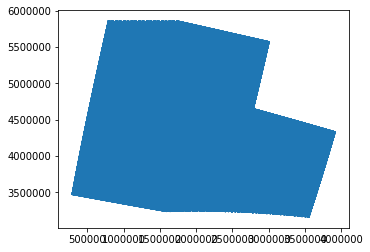

In [28]:
esa_s3.to_crs(plot_crs).plot();

# **OTHER USGS**

Login & grab token for **USGS EE API**

In [347]:
token_req = {
        "jsonRequest": json.dumps({
            "username": os.environ['USGS_USERNAME'],
            "password": os.environ['USGS_PWD'],
            "authType": "",
            "catalogId": 'EE'
        })
    }
r = requests.post(f'https://earthexplorer.usgs.gov/inventory/json/v/1.4.0/login', data=token_req)

print(r)
token = json.loads(r.text)['data']
token, json.loads(r.text)

<Response [200]>


('948fa27d811b4ad1b0b2326a9f8abf2e',
 {'errorCode': None,
  'error': '',
  'data': '948fa27d811b4ad1b0b2326a9f8abf2e',
  'api_version': '1.4.0',
  'access_level': 'user',
  'catalog_id': 'default',
  'executionTime': 0.36045098304748535})

# **MODIS First** 
MODIS_MCD43A4_V6 seems most useful product due to having BRDF already applied. Can be onerous to manually identify intersecting tiles, so to break it down...

In [14]:
# load world granules
world_sins = gpd.read_file('/tmp/data/modis_sinusoidal_grid_world.shp')

In [15]:
def sub2intersects(aoi_gpd, tiles_gpd, ref_crs, region_name):
    """
    Assumes aoi_gpd has NAME col and geomertries are all pre-loaded shapelies in geometry col'
    """
    aoi_gpd = aoi_gpd.to_crs(ref_crs)
    tiles_gpd = tiles_gpd.to_crs(ref_crs)
    
    for n, g in zip(aoi_gpd.NAME, aoi_gpd.geometry):
        tiles_gpd[n] = tiles_gpd.geometry.apply(lambda x: gpd.GeoSeries(x).intersects(g))
    # Filter based on any True intersections
    tiles_gpd[region_name] = tiles_gpd[tiles_gpd[aoi_gpd.NAME.values]].any(1)
    aoi_tiles = tiles_gpd[tiles_gpd[region_name]==True]
    aoi_tiles
    return aoi_tiles

In [16]:
aoi_modis_tiles = sub2intersects(aoi, world_sins, world_sins.crs, region_name)

In [64]:
def create_modtile_col(row):
    if row.h < 10:
        row.h = f'0{row.h}'
    if row.v < 10:
        row.v = f'0{row.v}'
    return f"H{row.h}_V{row.v}"

In [65]:
aoi_modis_tiles['tile'] = aoi_modis_tiles.apply(lambda row: create_modtile_col(row),axis=1)

In [66]:
aoi_modis_tiles

,cat,h,v,geometry,Fiji,tile
217,218,1,11,"POLYGON ((-18538518.667 -3343334.000, -1890888...",True,H01_V11
252,253,0,10,"POLYGON ((-19649629.667 -2232223.000, -2002000...",True,H00_V10
253,254,1,10,"POLYGON ((-18538518.667 -2232223.000, -1890888...",True,H01_V10
286,287,34,10,"POLYGON ((18128144.333 -2232223.000, 17757774....",True,H34_V10
287,288,35,10,"POLYGON ((19239255.333 -2232223.000, 18868885....",True,H35_V10


In [67]:
world_sins['tile'] = world_sins.apply(lambda row: create_modtile_col(row),axis=1)

in sinusoidal grid crs

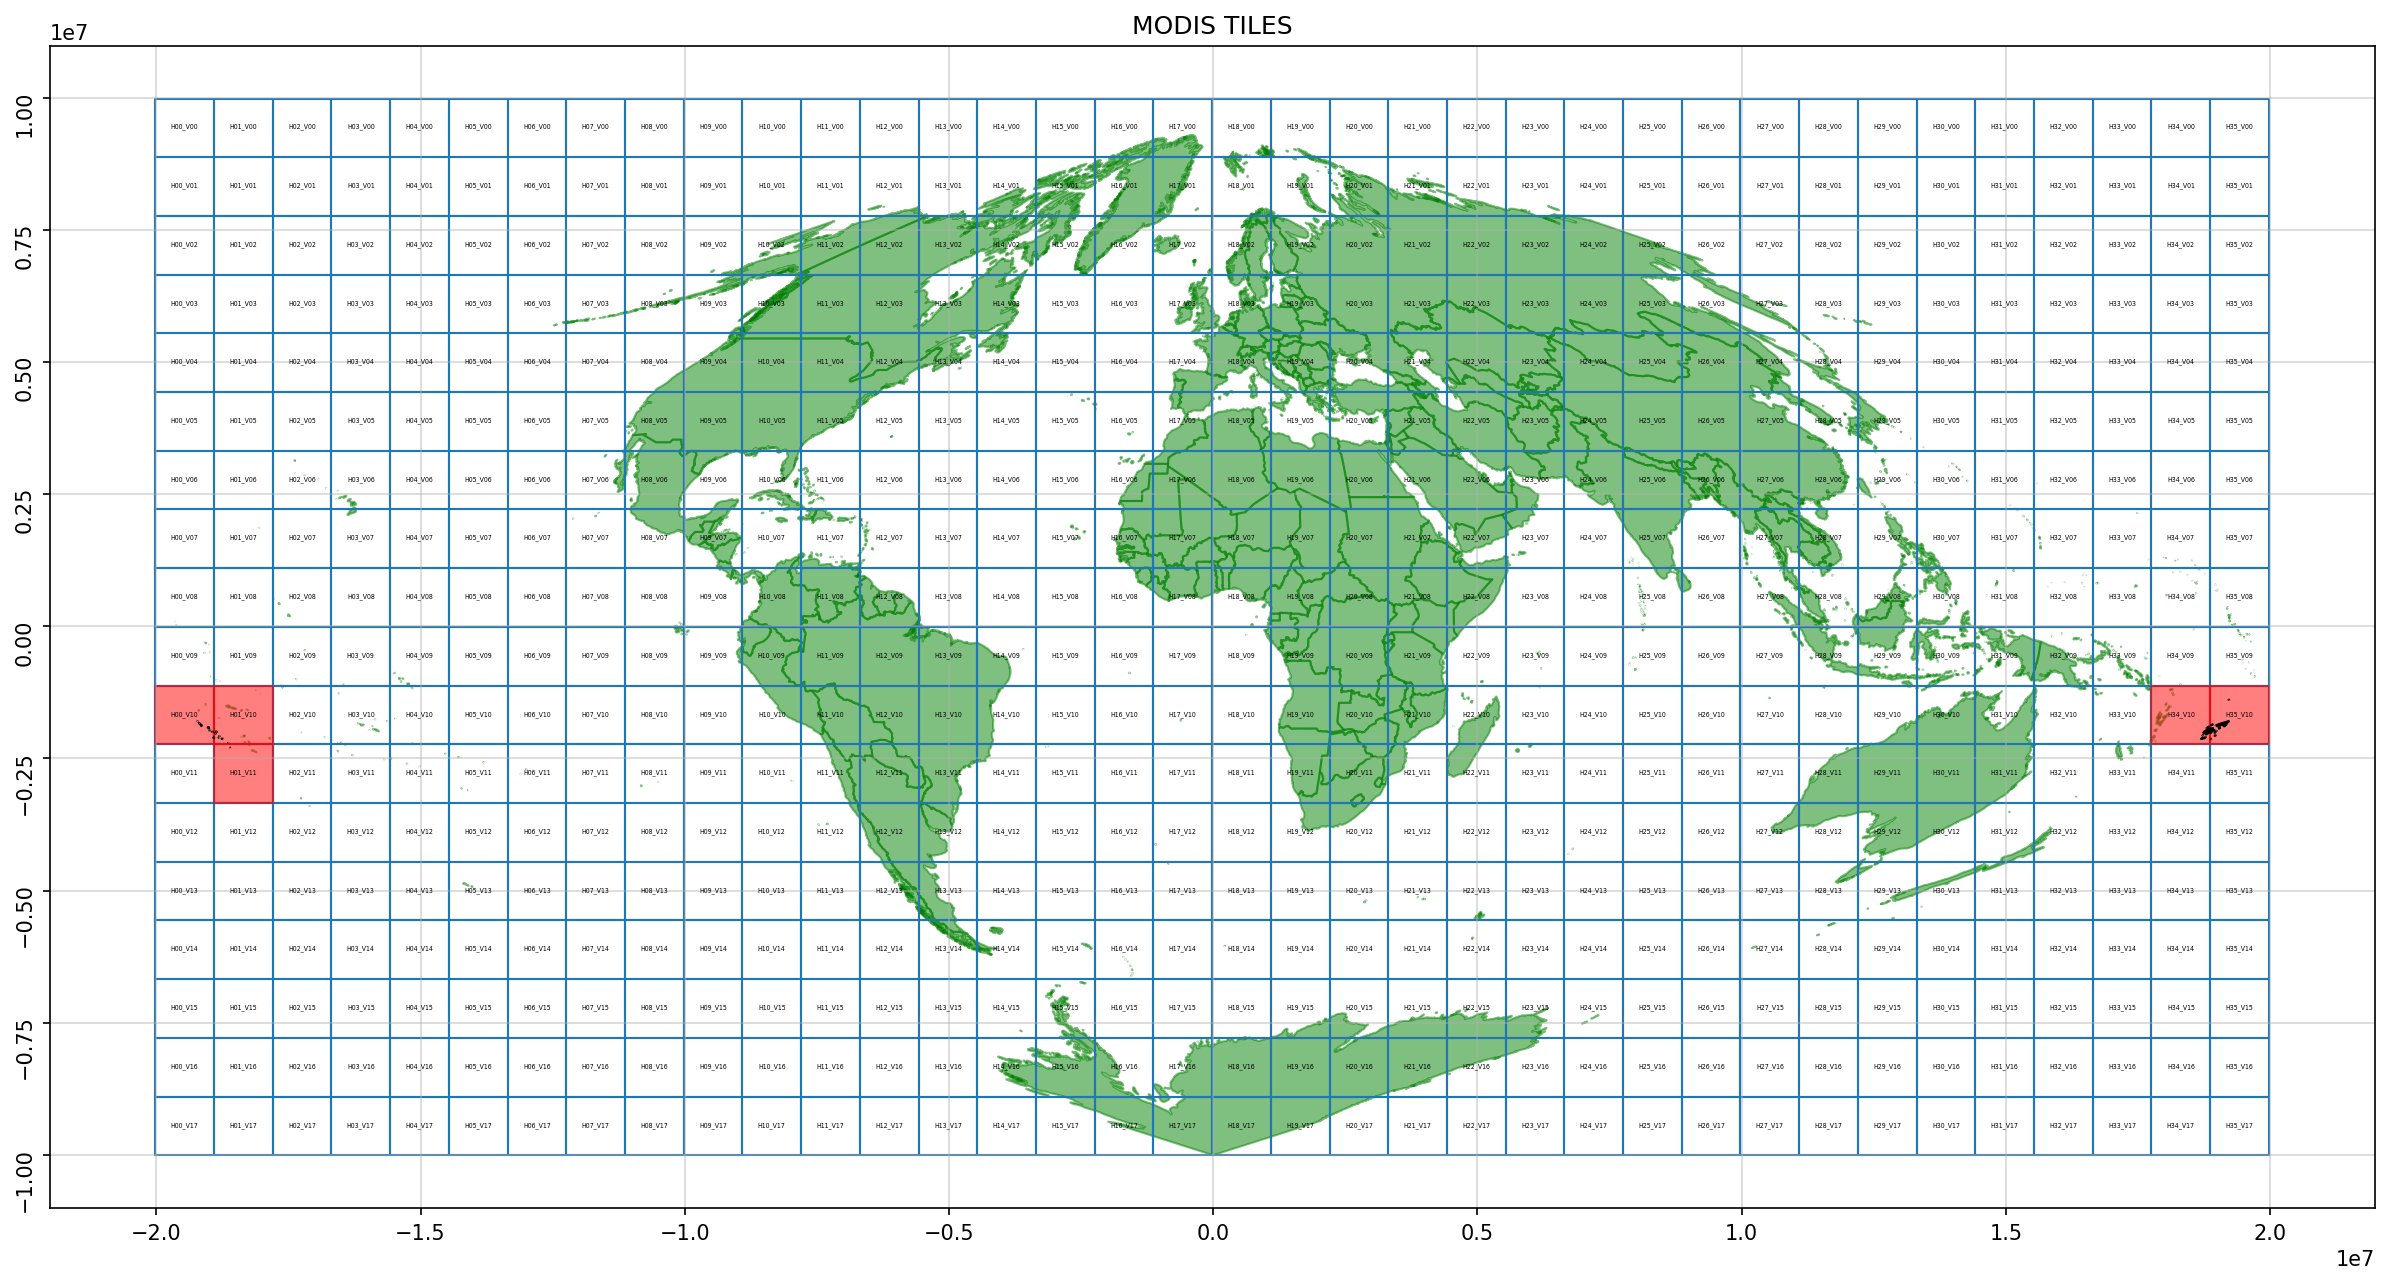

In [79]:
# Plot coverage
fig, ax = plt.subplots(figsize=(20,20),dpi=150)

world_borders.to_crs(world_sins.crs).plot(facecolor='g',edgecolor='g',alpha=0.5,ax=ax)

world_sins.to_crs(world_sins.crs).plot(facecolor='',edgecolor='C0', ax=ax)
world_sins.to_crs(world_sins.crs).apply(lambda x: ax.annotate(s=x.tile, xy=x.geometry.centroid.coords[0], ha='center', fontsize=3),axis=1)

aoi_modis_tiles.to_crs(world_sins.crs).plot(facecolor='r',edgecolor='r',alpha=0.5, ax=ax)

aoi.to_crs(world_sins.crs).plot(facecolor='black',edgecolor='black',alpha=1, ax=ax)



ax.set_title('MODIS TILES')
ax.grid(alpha=0.5);
ax.tick_params(axis='y', rotation=90);
ax.tick_params(axis='x', rotation=0);

in local grid

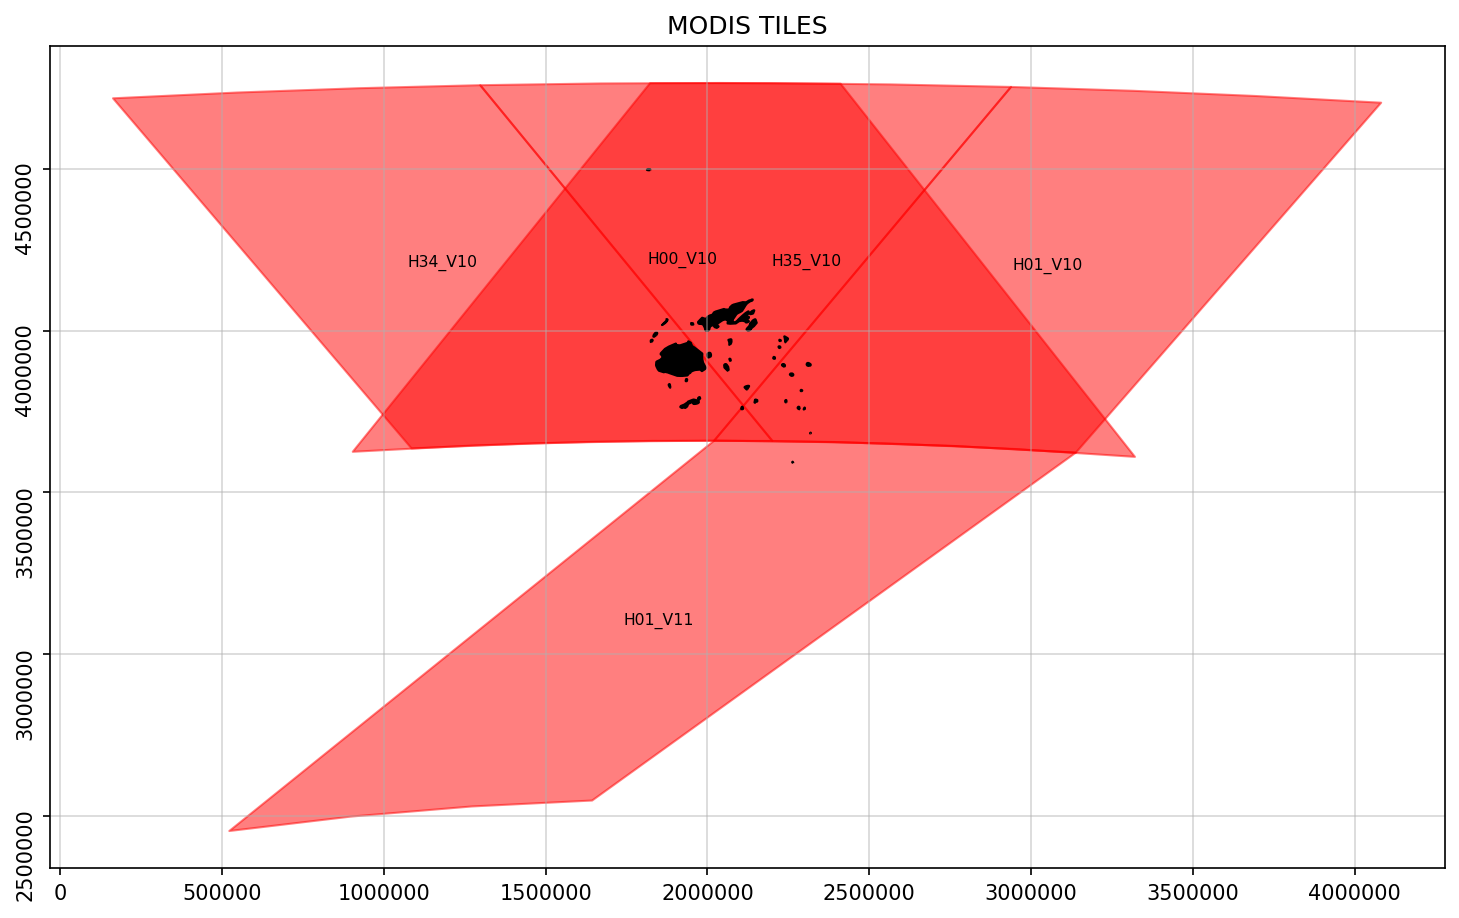

In [69]:
# Plot coverage
fig, ax = plt.subplots(figsize=(12,12),dpi=150)

# world_borders.to_crs(world_sins.crs).plot(facecolor='g',edgecolor='g',alpha=0.5,ax=ax)

# world_sins.to_crs(world_sins.crs).plot(facecolor='',edgecolor='C0', ax=ax)

aoi_modis_tiles.to_crs(plot_crs).plot(facecolor='r',edgecolor='r',alpha=0.5, ax=ax)
aoi_modis_tiles.to_crs(plot_crs).apply(lambda x: ax.annotate(s=x.tile, xy=x.geometry.centroid.coords[0], ha='center', fontsize=7.5),axis=1)

aoi.to_crs(plot_crs).plot(facecolor='black',edgecolor='black',alpha=1, ax=ax)



ax.set_title('MODIS TILES')
ax.grid(alpha=0.5);
ax.tick_params(axis='y', rotation=90);
ax.tick_params(axis='x', rotation=0);

we probably want to add a few extra to these in order to cover whole AOI with nice BBOX of data. we could probs combine with SI + VA since tiles are so large...(TBD)

In [70]:
aoi_modis_tiles

,cat,h,v,geometry,Fiji,tile
217,218,1,11,"POLYGON ((-18538518.667 -3343334.000, -1890888...",True,H01_V11
252,253,0,10,"POLYGON ((-19649629.667 -2232223.000, -2002000...",True,H00_V10
253,254,1,10,"POLYGON ((-18538518.667 -2232223.000, -1890888...",True,H01_V10
286,287,34,10,"POLYGON ((18128144.333 -2232223.000, 17757774....",True,H34_V10
287,288,35,10,"POLYGON ((19239255.333 -2232223.000, 18868885....",True,H35_V10


**Try USGS API**

**USGS temporarily down + v slow when available, so try hitting the LADD DAAC server...**
- Basic requests first to check if possible
- aiohttp would probs speed things up

Requests
- works! but super slow as expected due to response time + lack of parallelism

In [24]:

for y in range(2020,2021):
    m = []
    for d in tqdm(range(0,366)):

        if d <10:
            d = f"00{d}"
        elif (d >=10) & (d <100):
            d = f"0{d}"


        print(y, d)
        r = requests.get(f'https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/6/MCD43A4/{y}/{d}/.json')
        print(r)
#         print(r.text)
#         print(pd.DataFrame(json.loads(r.text)))
        try:

            m = m + json.loads(r.text)
        except:
            print('BOO')
    pd.DataFrame(m).to_csv(f'/tmp/data/outputs/SD_20200611_Fiji_MODIS_MCD43A4_V6_Y{y}.csv')

  0%|          | 0/366 [00:00<?, ?it/s]

2020 000


  0%|          | 1/366 [00:01<06:53,  1.13s/it]

<Response [400]>
BOO
2020 001


  1%|          | 2/366 [00:04<10:39,  1.76s/it]

<Response [200]>
2020 002


  1%|          | 3/366 [00:07<12:54,  2.13s/it]

<Response [200]>
2020 003


  1%|          | 4/366 [00:11<16:10,  2.68s/it]

<Response [200]>
2020 004


  1%|▏         | 5/366 [00:13<15:02,  2.50s/it]

<Response [200]>
2020 005


  2%|▏         | 6/366 [00:15<14:43,  2.45s/it]

<Response [200]>
2020 006


  2%|▏         | 7/366 [00:21<20:13,  3.38s/it]

<Response [200]>
2020 007


  2%|▏         | 8/366 [00:24<19:06,  3.20s/it]

<Response [200]>
2020 008


  2%|▏         | 9/366 [00:28<20:59,  3.53s/it]

<Response [200]>
2020 009


  3%|▎         | 10/366 [00:33<23:09,  3.90s/it]

<Response [200]>
2020 010


  3%|▎         | 11/366 [00:36<22:55,  3.88s/it]

<Response [200]>
2020 011


  3%|▎         | 12/366 [00:40<22:32,  3.82s/it]

<Response [200]>
2020 012


  4%|▎         | 13/366 [00:44<23:07,  3.93s/it]

<Response [200]>
2020 013


  4%|▍         | 14/366 [00:49<24:41,  4.21s/it]

<Response [200]>
2020 014


  4%|▍         | 15/366 [00:52<22:14,  3.80s/it]

<Response [200]>
2020 015


  4%|▍         | 16/366 [00:56<21:40,  3.72s/it]

<Response [200]>
2020 016


  5%|▍         | 17/366 [01:00<22:15,  3.83s/it]

<Response [200]>
2020 017


  5%|▍         | 18/366 [01:08<29:46,  5.13s/it]

<Response [200]>
2020 018


  5%|▌         | 19/366 [01:11<25:55,  4.48s/it]

<Response [200]>
2020 019


  5%|▌         | 20/366 [01:13<21:33,  3.74s/it]

<Response [200]>
2020 020


  6%|▌         | 21/366 [01:16<20:11,  3.51s/it]

<Response [200]>
2020 021


  6%|▌         | 22/366 [01:19<18:51,  3.29s/it]

<Response [200]>
2020 022


  6%|▋         | 23/366 [01:24<22:25,  3.92s/it]

<Response [200]>
2020 023


  7%|▋         | 24/366 [01:28<21:59,  3.86s/it]

<Response [200]>
2020 024


  7%|▋         | 25/366 [01:31<20:24,  3.59s/it]

<Response [200]>
2020 025


  7%|▋         | 26/366 [01:35<21:30,  3.80s/it]

<Response [200]>
2020 026


  7%|▋         | 27/366 [01:39<21:08,  3.74s/it]

<Response [200]>
2020 027


  8%|▊         | 28/366 [01:42<20:48,  3.69s/it]

<Response [200]>
2020 028


  8%|▊         | 29/366 [01:47<23:07,  4.12s/it]

<Response [200]>
2020 029


  8%|▊         | 30/366 [01:50<21:14,  3.79s/it]

<Response [200]>
2020 030


  8%|▊         | 31/366 [01:53<19:34,  3.51s/it]

<Response [200]>
2020 031


  9%|▊         | 32/366 [01:56<18:30,  3.33s/it]

<Response [200]>
2020 032


  9%|▉         | 33/366 [02:00<20:13,  3.64s/it]

<Response [200]>
2020 033


  9%|▉         | 34/366 [02:04<20:05,  3.63s/it]

<Response [200]>
2020 034


 10%|▉         | 35/366 [02:07<18:57,  3.44s/it]

<Response [200]>
2020 035


 10%|▉         | 36/366 [02:11<19:33,  3.56s/it]

<Response [200]>
2020 036


 10%|█         | 37/366 [02:13<17:14,  3.14s/it]

<Response [200]>
2020 037


 10%|█         | 38/366 [02:16<17:08,  3.13s/it]

<Response [200]>
2020 038


 11%|█         | 39/366 [02:19<16:23,  3.01s/it]

<Response [200]>
2020 039


 11%|█         | 40/366 [02:21<14:42,  2.71s/it]

<Response [200]>
2020 040


 11%|█         | 41/366 [02:23<13:23,  2.47s/it]

<Response [200]>
2020 041


 11%|█▏        | 42/366 [02:27<16:13,  3.00s/it]

<Response [200]>
2020 042


 12%|█▏        | 43/366 [02:29<14:49,  2.75s/it]

<Response [200]>
2020 043


 12%|█▏        | 44/366 [02:32<15:02,  2.80s/it]

<Response [200]>
2020 044


 12%|█▏        | 45/366 [02:37<17:48,  3.33s/it]

<Response [200]>
2020 045


 13%|█▎        | 46/366 [02:41<19:18,  3.62s/it]

<Response [200]>
2020 046


 13%|█▎        | 47/366 [02:44<18:49,  3.54s/it]

<Response [200]>
2020 047


 13%|█▎        | 48/366 [02:48<19:19,  3.65s/it]

<Response [200]>
2020 048


 13%|█▎        | 49/366 [02:59<31:01,  5.87s/it]

<Response [200]>
2020 049


 14%|█▎        | 50/366 [03:03<27:06,  5.15s/it]

<Response [200]>
2020 050


 14%|█▍        | 51/366 [03:06<24:44,  4.71s/it]

<Response [200]>
2020 051


 14%|█▍        | 52/366 [03:13<27:11,  5.19s/it]

<Response [200]>
2020 052


 14%|█▍        | 53/366 [03:16<24:02,  4.61s/it]

<Response [200]>
2020 053


 15%|█▍        | 54/366 [03:20<23:13,  4.47s/it]

<Response [200]>
2020 054


 15%|█▌        | 55/366 [03:25<23:59,  4.63s/it]

<Response [200]>
2020 055


 15%|█▌        | 56/366 [03:28<21:35,  4.18s/it]

<Response [200]>
2020 056


 16%|█▌        | 57/366 [03:32<21:21,  4.15s/it]

<Response [200]>
2020 057


 16%|█▌        | 58/366 [03:36<20:01,  3.90s/it]

<Response [200]>
2020 058


 16%|█▌        | 59/366 [03:38<17:43,  3.47s/it]

<Response [200]>
2020 059


 16%|█▋        | 60/366 [03:40<15:16,  3.00s/it]

<Response [200]>
2020 060


 17%|█▋        | 61/366 [03:42<14:09,  2.79s/it]

<Response [200]>
2020 061


 17%|█▋        | 62/366 [03:45<14:25,  2.85s/it]

<Response [200]>
2020 062


 17%|█▋        | 63/366 [03:48<13:50,  2.74s/it]

<Response [200]>
2020 063


 17%|█▋        | 64/366 [03:55<20:19,  4.04s/it]

<Response [200]>
2020 064


 18%|█▊        | 65/366 [03:58<19:14,  3.84s/it]

<Response [200]>
2020 065


 18%|█▊        | 66/366 [04:01<16:58,  3.40s/it]

<Response [200]>
2020 066


 18%|█▊        | 67/366 [04:04<17:34,  3.53s/it]

<Response [200]>
2020 067


 19%|█▊        | 68/366 [04:08<17:25,  3.51s/it]

<Response [200]>
2020 068


 19%|█▉        | 69/366 [04:09<13:52,  2.80s/it]

<Response [200]>
2020 069


 19%|█▉        | 70/366 [04:12<13:56,  2.83s/it]

<Response [200]>
2020 070


 19%|█▉        | 71/366 [04:16<15:59,  3.25s/it]

<Response [200]>
2020 071


 20%|█▉        | 72/366 [04:21<17:48,  3.63s/it]

<Response [200]>
2020 072


 20%|█▉        | 73/366 [04:26<20:31,  4.20s/it]

<Response [200]>
2020 073


 20%|██        | 74/366 [04:30<19:30,  4.01s/it]

<Response [200]>
2020 074


 20%|██        | 75/366 [04:33<17:55,  3.70s/it]

<Response [200]>
2020 075


 21%|██        | 76/366 [04:35<16:34,  3.43s/it]

<Response [200]>
2020 076


 21%|██        | 77/366 [04:38<15:17,  3.17s/it]

<Response [200]>
2020 077


 21%|██▏       | 78/366 [04:41<14:53,  3.10s/it]

<Response [200]>
2020 078


 22%|██▏       | 79/366 [04:45<16:22,  3.42s/it]

<Response [200]>
2020 079


 22%|██▏       | 80/366 [04:49<17:05,  3.59s/it]

<Response [200]>
2020 080


 22%|██▏       | 81/366 [04:53<16:48,  3.54s/it]

<Response [200]>
2020 081


 22%|██▏       | 82/366 [04:55<15:34,  3.29s/it]

<Response [200]>
2020 082


 23%|██▎       | 83/366 [04:59<16:41,  3.54s/it]

<Response [200]>
2020 083


 23%|██▎       | 84/366 [05:05<18:58,  4.04s/it]

<Response [200]>
2020 084


 23%|██▎       | 85/366 [05:08<18:14,  3.90s/it]

<Response [200]>
2020 085


 23%|██▎       | 86/366 [05:11<16:19,  3.50s/it]

<Response [200]>
2020 086


 24%|██▍       | 87/366 [05:12<13:45,  2.96s/it]

<Response [200]>
2020 087


 24%|██▍       | 88/366 [05:15<13:00,  2.81s/it]

<Response [200]>
2020 088


 24%|██▍       | 89/366 [05:17<12:00,  2.60s/it]

<Response [200]>
2020 089


 25%|██▍       | 90/366 [05:19<11:23,  2.48s/it]

<Response [200]>
2020 090


 25%|██▍       | 91/366 [05:21<10:01,  2.19s/it]

<Response [200]>
2020 091


 25%|██▌       | 92/366 [05:26<13:45,  3.01s/it]

<Response [200]>
2020 092


 25%|██▌       | 93/366 [05:28<12:41,  2.79s/it]

<Response [200]>
2020 093


 26%|██▌       | 94/366 [05:32<13:54,  3.07s/it]

<Response [200]>
2020 094


 26%|██▌       | 95/366 [05:35<14:36,  3.23s/it]

<Response [200]>
2020 095


 26%|██▌       | 96/366 [05:39<15:20,  3.41s/it]

<Response [200]>
2020 096


 27%|██▋       | 97/366 [05:46<19:30,  4.35s/it]

<Response [200]>
2020 097


 27%|██▋       | 98/366 [05:49<17:45,  3.97s/it]

<Response [200]>
2020 098


 27%|██▋       | 99/366 [05:53<17:37,  3.96s/it]

<Response [200]>
2020 099


 27%|██▋       | 100/366 [05:59<21:04,  4.75s/it]

<Response [200]>
2020 100


 28%|██▊       | 101/366 [06:04<20:28,  4.64s/it]

<Response [200]>
2020 101


 28%|██▊       | 102/366 [06:09<21:07,  4.80s/it]

<Response [200]>
2020 102


 28%|██▊       | 103/366 [06:13<20:14,  4.62s/it]

<Response [200]>
2020 103


 28%|██▊       | 104/366 [06:17<18:48,  4.31s/it]

<Response [200]>
2020 104


 29%|██▊       | 105/366 [06:21<18:27,  4.24s/it]

<Response [200]>
2020 105


 29%|██▉       | 106/366 [06:24<16:54,  3.90s/it]

<Response [200]>
2020 106


 29%|██▉       | 107/366 [06:29<18:13,  4.22s/it]

<Response [200]>
2020 107


 30%|██▉       | 108/366 [06:34<18:55,  4.40s/it]

<Response [200]>
2020 108


 30%|██▉       | 109/366 [06:39<19:50,  4.63s/it]

<Response [200]>
2020 109


 30%|███       | 110/366 [06:45<21:25,  5.02s/it]

<Response [200]>
2020 110


 30%|███       | 111/366 [06:49<20:42,  4.87s/it]

<Response [200]>
2020 111


 31%|███       | 112/366 [06:53<19:47,  4.68s/it]

<Response [200]>
2020 112


 31%|███       | 113/366 [06:58<20:04,  4.76s/it]

<Response [200]>
2020 113


 31%|███       | 114/366 [07:01<17:38,  4.20s/it]

<Response [200]>
2020 114


 31%|███▏      | 115/366 [07:06<18:27,  4.41s/it]

<Response [200]>
2020 115


 32%|███▏      | 116/366 [07:08<15:15,  3.66s/it]

<Response [200]>
2020 116


 32%|███▏      | 117/366 [07:10<12:41,  3.06s/it]

<Response [200]>
2020 117


 32%|███▏      | 118/366 [07:13<12:19,  2.98s/it]

<Response [200]>
2020 118


 33%|███▎      | 119/366 [07:15<11:52,  2.88s/it]

<Response [200]>
2020 119


 33%|███▎      | 120/366 [07:18<11:38,  2.84s/it]

<Response [200]>
2020 120


 33%|███▎      | 121/366 [07:22<13:13,  3.24s/it]

<Response [200]>
2020 121


 33%|███▎      | 122/366 [07:25<12:52,  3.17s/it]

<Response [200]>
2020 122


 34%|███▎      | 123/366 [07:28<12:47,  3.16s/it]

<Response [200]>
2020 123


 34%|███▍      | 124/366 [07:31<12:11,  3.02s/it]

<Response [200]>
2020 124


 34%|███▍      | 125/366 [07:35<12:53,  3.21s/it]

<Response [200]>
2020 125


 34%|███▍      | 126/366 [07:39<14:35,  3.65s/it]

<Response [200]>
2020 126


 35%|███▍      | 127/366 [07:43<14:59,  3.76s/it]

<Response [200]>
2020 127


 35%|███▍      | 128/366 [07:47<14:37,  3.69s/it]

<Response [200]>
2020 128


 35%|███▌      | 129/366 [07:51<15:24,  3.90s/it]

<Response [200]>
2020 129


 36%|███▌      | 130/366 [07:55<15:11,  3.86s/it]

<Response [200]>
2020 130


 36%|███▌      | 131/366 [07:58<13:56,  3.56s/it]

<Response [200]>
2020 131


 36%|███▌      | 132/366 [08:02<14:11,  3.64s/it]

<Response [200]>
2020 132


 36%|███▋      | 133/366 [08:06<15:29,  3.99s/it]

<Response [200]>
2020 133


 37%|███▋      | 134/366 [08:12<17:10,  4.44s/it]

<Response [200]>
2020 134


 37%|███▋      | 135/366 [08:18<18:54,  4.91s/it]

<Response [200]>
2020 135


 37%|███▋      | 136/366 [08:21<16:32,  4.32s/it]

<Response [200]>
2020 136


 37%|███▋      | 137/366 [08:24<15:22,  4.03s/it]

<Response [200]>
2020 137


 38%|███▊      | 138/366 [08:29<16:41,  4.39s/it]

<Response [200]>
2020 138


 38%|███▊      | 139/366 [08:32<15:02,  3.98s/it]

<Response [200]>
2020 139


 38%|███▊      | 140/366 [08:37<15:15,  4.05s/it]

<Response [200]>
2020 140


 39%|███▊      | 141/366 [08:41<15:49,  4.22s/it]

<Response [200]>
2020 141


 39%|███▉      | 142/366 [08:44<14:28,  3.88s/it]

<Response [200]>
2020 142


 39%|███▉      | 143/366 [08:52<18:27,  4.97s/it]

<Response [200]>
2020 143


 39%|███▉      | 144/366 [08:58<20:10,  5.45s/it]

<Response [200]>
2020 144


 40%|███▉      | 145/366 [09:00<16:14,  4.41s/it]

<Response [200]>
2020 145


 40%|███▉      | 146/366 [09:03<14:19,  3.91s/it]

<Response [200]>
2020 146


 40%|████      | 147/366 [09:07<14:06,  3.86s/it]

<Response [200]>
2020 147


 40%|████      | 148/366 [09:10<12:37,  3.48s/it]

<Response [200]>
2020 148


 41%|████      | 149/366 [09:12<11:50,  3.28s/it]

<Response [200]>
2020 149


 41%|████      | 150/366 [09:16<12:38,  3.51s/it]

<Response [200]>
2020 150


 41%|████▏     | 151/366 [09:19<11:55,  3.33s/it]

<Response [200]>
2020 151


 42%|████▏     | 152/366 [09:22<10:58,  3.08s/it]

<Response [200]>
2020 152


 42%|████▏     | 153/366 [09:23<09:05,  2.56s/it]

<Response [200]>
2020 153


 42%|████▏     | 154/366 [09:24<07:34,  2.14s/it]

<Response [200]>
2020 154


 42%|████▏     | 155/366 [09:25<06:26,  1.83s/it]

<Response [200]>
2020 155


 43%|████▎     | 156/366 [09:27<06:07,  1.75s/it]

<Response [200]>
2020 156


 43%|████▎     | 157/366 [09:29<05:56,  1.70s/it]

<Response [200]>
2020 157


 43%|████▎     | 158/366 [09:30<05:35,  1.61s/it]

<Response [200]>
2020 158


 43%|████▎     | 159/366 [09:32<05:29,  1.59s/it]

<Response [200]>
2020 159


 44%|████▎     | 160/366 [09:33<05:11,  1.51s/it]

<Response [200]>
2020 160


 44%|████▍     | 161/366 [09:35<05:28,  1.60s/it]

<Response [200]>
2020 161


 44%|████▍     | 162/366 [09:36<05:02,  1.48s/it]

<Response [200]>
2020 162


 45%|████▍     | 163/366 [09:37<04:41,  1.39s/it]

<Response [200]>
2020 163


 45%|████▍     | 164/366 [09:39<04:48,  1.43s/it]

<Response [200]>
2020 164


 45%|████▌     | 165/366 [09:40<04:47,  1.43s/it]

<Response [200]>
2020 165


 45%|████▌     | 166/366 [09:42<04:51,  1.46s/it]

<Response [200]>
2020 166


 46%|████▌     | 167/366 [09:43<04:34,  1.38s/it]

<Response [200]>
2020 167


 46%|████▌     | 168/366 [09:44<04:22,  1.33s/it]

<Response [200]>
2020 168


 46%|████▌     | 169/366 [09:45<04:07,  1.26s/it]

<Response [200]>
2020 169


 46%|████▋     | 170/366 [09:46<04:02,  1.24s/it]

<Response [200]>
2020 170


 47%|████▋     | 171/366 [09:47<03:54,  1.20s/it]

<Response [200]>
2020 171


 47%|████▋     | 172/366 [09:49<04:02,  1.25s/it]

<Response [200]>
2020 172


 47%|████▋     | 173/366 [09:50<03:58,  1.24s/it]

<Response [200]>
2020 173


 48%|████▊     | 174/366 [09:51<03:37,  1.13s/it]

<Response [200]>
2020 174


 48%|████▊     | 175/366 [09:51<03:03,  1.04it/s]

<Response [400]>
BOO
2020 175


 48%|████▊     | 176/366 [09:52<02:40,  1.18it/s]

<Response [400]>
BOO
2020 176


 48%|████▊     | 177/366 [09:52<02:23,  1.31it/s]

<Response [400]>
BOO
2020 177


 49%|████▊     | 178/366 [09:53<02:13,  1.41it/s]

<Response [400]>
BOO
2020 178


 49%|████▉     | 179/366 [09:54<02:03,  1.51it/s]

<Response [400]>
BOO
2020 179


 49%|████▉     | 180/366 [09:54<01:56,  1.59it/s]

<Response [400]>
BOO
2020 180


 49%|████▉     | 181/366 [09:55<01:52,  1.64it/s]

<Response [400]>
BOO
2020 181


 50%|████▉     | 182/366 [09:55<01:59,  1.54it/s]

<Response [400]>
BOO
2020 182


 50%|█████     | 183/366 [09:56<01:53,  1.61it/s]

<Response [400]>
BOO
2020 183


 50%|█████     | 184/366 [09:57<01:49,  1.66it/s]

<Response [400]>
BOO
2020 184


 51%|█████     | 185/366 [09:57<01:46,  1.70it/s]

<Response [400]>
BOO
2020 185


 51%|█████     | 186/366 [09:58<01:43,  1.75it/s]

<Response [400]>
BOO
2020 186


 51%|█████     | 187/366 [09:58<01:41,  1.77it/s]

<Response [400]>
BOO
2020 187


 51%|█████▏    | 188/366 [09:59<01:40,  1.77it/s]

<Response [400]>
BOO
2020 188


 52%|█████▏    | 189/366 [09:59<01:39,  1.78it/s]

<Response [400]>
BOO
2020 189


 52%|█████▏    | 190/366 [10:00<01:38,  1.78it/s]

<Response [400]>
BOO
2020 190


 52%|█████▏    | 191/366 [10:00<01:37,  1.79it/s]

<Response [400]>
BOO
2020 191


 52%|█████▏    | 192/366 [10:01<01:35,  1.82it/s]

<Response [400]>
BOO
2020 192


 53%|█████▎    | 193/366 [10:02<01:35,  1.81it/s]

<Response [400]>
BOO
2020 193


 53%|█████▎    | 194/366 [10:02<01:34,  1.81it/s]

<Response [400]>
BOO
2020 194


 53%|█████▎    | 195/366 [10:03<01:34,  1.82it/s]

<Response [400]>
BOO
2020 195


 54%|█████▎    | 196/366 [10:03<01:33,  1.82it/s]

<Response [400]>
BOO
2020 196


 54%|█████▍    | 197/366 [10:04<01:32,  1.82it/s]

<Response [400]>
BOO
2020 197


 54%|█████▍    | 198/366 [10:04<01:34,  1.78it/s]

<Response [400]>
BOO
2020 198


 54%|█████▍    | 199/366 [10:05<01:33,  1.79it/s]

<Response [400]>
BOO
2020 199


 55%|█████▍    | 200/366 [10:05<01:31,  1.81it/s]

<Response [400]>
BOO
2020 200


 55%|█████▍    | 201/366 [10:06<01:30,  1.83it/s]

<Response [400]>
BOO
2020 201


 55%|█████▌    | 202/366 [10:07<01:31,  1.79it/s]

<Response [400]>
BOO
2020 202


 55%|█████▌    | 203/366 [10:07<01:30,  1.80it/s]

<Response [400]>
BOO
2020 203


 56%|█████▌    | 204/366 [10:08<01:29,  1.82it/s]

<Response [400]>
BOO
2020 204


 56%|█████▌    | 205/366 [10:08<01:29,  1.79it/s]

<Response [400]>
BOO
2020 205


 56%|█████▋    | 206/366 [10:09<01:28,  1.80it/s]

<Response [400]>
BOO
2020 206


 57%|█████▋    | 207/366 [10:09<01:28,  1.80it/s]

<Response [400]>
BOO
2020 207


 57%|█████▋    | 208/366 [10:10<01:26,  1.82it/s]

<Response [400]>
BOO
2020 208


 57%|█████▋    | 209/366 [10:10<01:26,  1.82it/s]

<Response [400]>
BOO
2020 209


 57%|█████▋    | 210/366 [10:11<01:25,  1.83it/s]

<Response [400]>
BOO
2020 210


 58%|█████▊    | 211/366 [10:12<01:27,  1.76it/s]

<Response [400]>
BOO
2020 211


 58%|█████▊    | 212/366 [10:12<01:26,  1.78it/s]

<Response [400]>
BOO
2020 212


 58%|█████▊    | 213/366 [10:13<01:26,  1.78it/s]

<Response [400]>
BOO
2020 213


 58%|█████▊    | 214/366 [10:13<01:26,  1.76it/s]

<Response [400]>
BOO
2020 214


 59%|█████▊    | 215/366 [10:14<01:25,  1.76it/s]

<Response [400]>
BOO
2020 215


 59%|█████▉    | 216/366 [10:14<01:24,  1.77it/s]

<Response [400]>
BOO
2020 216


 59%|█████▉    | 217/366 [10:15<01:25,  1.75it/s]

<Response [400]>
BOO
2020 217


 60%|█████▉    | 218/366 [10:16<01:23,  1.78it/s]

<Response [400]>
BOO
2020 218


 60%|█████▉    | 219/366 [10:16<01:22,  1.79it/s]

<Response [400]>
BOO
2020 219


 60%|██████    | 220/366 [10:17<01:20,  1.80it/s]

<Response [400]>
BOO
2020 220


 60%|██████    | 221/366 [10:17<01:19,  1.82it/s]

<Response [400]>
BOO
2020 221


 61%|██████    | 222/366 [10:18<01:19,  1.81it/s]

<Response [400]>
BOO
2020 222


 61%|██████    | 223/366 [10:18<01:18,  1.83it/s]

<Response [400]>
BOO
2020 223


 61%|██████    | 224/366 [10:19<01:17,  1.83it/s]

<Response [400]>
BOO
2020 224


 61%|██████▏   | 225/366 [10:19<01:17,  1.83it/s]

<Response [400]>
BOO
2020 225


 62%|██████▏   | 226/366 [10:20<01:16,  1.84it/s]

<Response [400]>
BOO
2020 226


 62%|██████▏   | 227/366 [10:20<01:15,  1.84it/s]

<Response [400]>
BOO
2020 227


 62%|██████▏   | 228/366 [10:21<01:14,  1.84it/s]

<Response [400]>
BOO
2020 228


 63%|██████▎   | 229/366 [10:21<01:13,  1.86it/s]

<Response [400]>
BOO
2020 229


 63%|██████▎   | 230/366 [10:22<01:13,  1.86it/s]

<Response [400]>
BOO
2020 230


 63%|██████▎   | 231/366 [10:23<01:13,  1.85it/s]

<Response [400]>
BOO
2020 231


 63%|██████▎   | 232/366 [10:23<01:11,  1.86it/s]

<Response [400]>
BOO
2020 232


 64%|██████▎   | 233/366 [10:24<01:11,  1.86it/s]

<Response [400]>
BOO
2020 233


 64%|██████▍   | 234/366 [10:24<01:23,  1.58it/s]

<Response [400]>
BOO
2020 234


 64%|██████▍   | 235/366 [10:25<01:19,  1.65it/s]

<Response [400]>
BOO
2020 235


 64%|██████▍   | 236/366 [10:26<01:17,  1.68it/s]

<Response [400]>
BOO
2020 236


 65%|██████▍   | 237/366 [10:26<01:15,  1.72it/s]

<Response [400]>
BOO
2020 237


 65%|██████▌   | 238/366 [10:27<01:24,  1.52it/s]

<Response [400]>
BOO
2020 238


 65%|██████▌   | 239/366 [10:28<01:20,  1.59it/s]

<Response [400]>
BOO
2020 239


 66%|██████▌   | 240/366 [10:28<01:16,  1.66it/s]

<Response [400]>
BOO
2020 240


 66%|██████▌   | 241/366 [10:29<01:13,  1.69it/s]

<Response [400]>
BOO
2020 241


 66%|██████▌   | 242/366 [10:29<01:11,  1.72it/s]

<Response [400]>
BOO
2020 242


 66%|██████▋   | 243/366 [10:30<01:11,  1.73it/s]

<Response [400]>
BOO
2020 243


 67%|██████▋   | 244/366 [10:30<01:09,  1.76it/s]

<Response [400]>
BOO
2020 244


 67%|██████▋   | 245/366 [10:31<01:08,  1.78it/s]

<Response [400]>
BOO
2020 245


 67%|██████▋   | 246/366 [10:32<01:17,  1.54it/s]

<Response [400]>
BOO
2020 246


 67%|██████▋   | 247/366 [10:32<01:13,  1.62it/s]

<Response [400]>
BOO
2020 247


 68%|██████▊   | 248/366 [10:33<01:10,  1.67it/s]

<Response [400]>
BOO
2020 248


 68%|██████▊   | 249/366 [10:34<01:27,  1.34it/s]

<Response [400]>
BOO
2020 249


 68%|██████▊   | 250/366 [10:34<01:19,  1.46it/s]

<Response [400]>
BOO
2020 250


 69%|██████▊   | 251/366 [10:35<01:14,  1.55it/s]

<Response [400]>
BOO
2020 251


 69%|██████▉   | 252/366 [10:36<01:10,  1.63it/s]

<Response [400]>
BOO
2020 252


 69%|██████▉   | 253/366 [10:36<01:07,  1.68it/s]

<Response [400]>
BOO
2020 253


 69%|██████▉   | 254/366 [10:37<01:05,  1.70it/s]

<Response [400]>
BOO
2020 254


 70%|██████▉   | 255/366 [10:37<01:03,  1.74it/s]

<Response [400]>
BOO
2020 255


 70%|██████▉   | 256/366 [10:38<01:02,  1.76it/s]

<Response [400]>
BOO
2020 256


 70%|███████   | 257/366 [10:38<01:01,  1.78it/s]

<Response [400]>
BOO
2020 257


 70%|███████   | 258/366 [10:39<01:00,  1.79it/s]

<Response [400]>
BOO
2020 258


 71%|███████   | 259/366 [10:39<00:59,  1.80it/s]

<Response [400]>
BOO
2020 259


 71%|███████   | 260/366 [10:40<00:59,  1.79it/s]

<Response [400]>
BOO
2020 260


 71%|███████▏  | 261/366 [10:41<00:58,  1.79it/s]

<Response [400]>
BOO
2020 261


 72%|███████▏  | 262/366 [10:41<00:57,  1.81it/s]

<Response [400]>
BOO
2020 262


 72%|███████▏  | 263/366 [10:42<00:58,  1.77it/s]

<Response [400]>
BOO
2020 263


 72%|███████▏  | 264/366 [10:42<00:57,  1.78it/s]

<Response [400]>
BOO
2020 264


 72%|███████▏  | 265/366 [10:43<00:55,  1.81it/s]

<Response [400]>
BOO
2020 265


 73%|███████▎  | 266/366 [10:43<00:55,  1.81it/s]

<Response [400]>
BOO
2020 266


 73%|███████▎  | 267/366 [10:44<00:54,  1.83it/s]

<Response [400]>
BOO
2020 267


 73%|███████▎  | 268/366 [10:44<00:53,  1.83it/s]

<Response [400]>
BOO
2020 268


 73%|███████▎  | 269/366 [10:45<00:54,  1.79it/s]

<Response [400]>
BOO
2020 269


 74%|███████▍  | 270/366 [10:46<00:53,  1.79it/s]

<Response [400]>
BOO
2020 270


 74%|███████▍  | 271/366 [10:46<00:52,  1.81it/s]

<Response [400]>
BOO
2020 271


 74%|███████▍  | 272/366 [10:47<00:52,  1.80it/s]

<Response [400]>
BOO
2020 272


 75%|███████▍  | 273/366 [10:47<00:51,  1.79it/s]

<Response [400]>
BOO
2020 273


 75%|███████▍  | 274/366 [10:48<00:51,  1.80it/s]

<Response [400]>
BOO
2020 274


 75%|███████▌  | 275/366 [10:48<00:50,  1.81it/s]

<Response [400]>
BOO
2020 275


 75%|███████▌  | 276/366 [10:49<00:50,  1.78it/s]

<Response [400]>
BOO
2020 276


 76%|███████▌  | 277/366 [10:49<00:49,  1.80it/s]

<Response [400]>
BOO
2020 277


 76%|███████▌  | 278/366 [10:50<00:48,  1.81it/s]

<Response [400]>
BOO
2020 278


 76%|███████▌  | 279/366 [10:50<00:47,  1.82it/s]

<Response [400]>
BOO
2020 279


 77%|███████▋  | 280/366 [10:51<00:47,  1.83it/s]

<Response [400]>
BOO
2020 280


 77%|███████▋  | 281/366 [10:52<00:46,  1.82it/s]

<Response [400]>
BOO
2020 281


 77%|███████▋  | 282/366 [10:52<00:46,  1.82it/s]

<Response [400]>
BOO
2020 282


 77%|███████▋  | 283/366 [10:53<00:45,  1.82it/s]

<Response [400]>
BOO
2020 283


 78%|███████▊  | 284/366 [10:53<00:45,  1.82it/s]

<Response [400]>
BOO
2020 284


 78%|███████▊  | 285/366 [10:54<00:44,  1.83it/s]

<Response [400]>
BOO
2020 285


 78%|███████▊  | 286/366 [10:54<00:43,  1.84it/s]

<Response [400]>
BOO
2020 286


 78%|███████▊  | 287/366 [10:55<00:42,  1.84it/s]

<Response [400]>
BOO
2020 287


 79%|███████▊  | 288/366 [10:56<00:47,  1.63it/s]

<Response [400]>
BOO
2020 288


 79%|███████▉  | 289/366 [10:56<00:45,  1.68it/s]

<Response [400]>
BOO
2020 289


 79%|███████▉  | 290/366 [10:57<00:44,  1.69it/s]

<Response [400]>
BOO
2020 290


 80%|███████▉  | 291/366 [10:57<00:43,  1.73it/s]

<Response [400]>
BOO
2020 291


 80%|███████▉  | 292/366 [10:58<00:42,  1.75it/s]

<Response [400]>
BOO
2020 292


 80%|████████  | 293/366 [10:58<00:41,  1.77it/s]

<Response [400]>
BOO
2020 293


 80%|████████  | 294/366 [10:59<00:41,  1.75it/s]

<Response [400]>
BOO
2020 294


 81%|████████  | 295/366 [11:00<00:40,  1.77it/s]

<Response [400]>
BOO
2020 295


 81%|████████  | 296/366 [11:00<00:39,  1.79it/s]

<Response [400]>
BOO
2020 296


 81%|████████  | 297/366 [11:01<00:38,  1.81it/s]

<Response [400]>
BOO
2020 297


 81%|████████▏ | 298/366 [11:01<00:37,  1.80it/s]

<Response [400]>
BOO
2020 298


 82%|████████▏ | 299/366 [11:02<00:37,  1.81it/s]

<Response [400]>
BOO
2020 299


 82%|████████▏ | 300/366 [11:02<00:36,  1.81it/s]

<Response [400]>
BOO
2020 300


 82%|████████▏ | 301/366 [11:03<00:35,  1.82it/s]

<Response [400]>
BOO
2020 301


 83%|████████▎ | 302/366 [11:03<00:35,  1.81it/s]

<Response [400]>
BOO
2020 302


 83%|████████▎ | 303/366 [11:04<00:34,  1.82it/s]

<Response [400]>
BOO
2020 303


 83%|████████▎ | 304/366 [11:04<00:33,  1.83it/s]

<Response [400]>
BOO
2020 304


 83%|████████▎ | 305/366 [11:05<00:33,  1.81it/s]

<Response [400]>
BOO
2020 305


 84%|████████▎ | 306/366 [11:06<00:32,  1.82it/s]

<Response [400]>
BOO
2020 306


 84%|████████▍ | 307/366 [11:06<00:32,  1.83it/s]

<Response [400]>
BOO
2020 307


 84%|████████▍ | 308/366 [11:07<00:31,  1.84it/s]

<Response [400]>
BOO
2020 308


 84%|████████▍ | 309/366 [11:07<00:31,  1.83it/s]

<Response [400]>
BOO
2020 309


 85%|████████▍ | 310/366 [11:08<00:30,  1.83it/s]

<Response [400]>
BOO
2020 310


 85%|████████▍ | 311/366 [11:08<00:30,  1.82it/s]

<Response [400]>
BOO
2020 311


 85%|████████▌ | 312/366 [11:09<00:29,  1.83it/s]

<Response [400]>
BOO
2020 312


 86%|████████▌ | 313/366 [11:09<00:29,  1.82it/s]

<Response [400]>
BOO
2020 313


 86%|████████▌ | 314/366 [11:11<00:37,  1.38it/s]

<Response [400]>
BOO
2020 314


 86%|████████▌ | 315/366 [11:11<00:34,  1.50it/s]

<Response [400]>
BOO
2020 315


 86%|████████▋ | 316/366 [11:12<00:31,  1.59it/s]

<Response [400]>
BOO
2020 316


 87%|████████▋ | 317/366 [11:16<01:23,  1.71s/it]

<Response [400]>
BOO
2020 317


 87%|████████▋ | 318/366 [11:16<01:05,  1.37s/it]

<Response [400]>
BOO
2020 318


 87%|████████▋ | 319/366 [11:17<00:52,  1.12s/it]

<Response [400]>
BOO
2020 319


 87%|████████▋ | 320/366 [11:18<00:43,  1.05it/s]

<Response [400]>
BOO
2020 320


 88%|████████▊ | 321/366 [11:18<00:37,  1.20it/s]

<Response [400]>
BOO
2020 321


 88%|████████▊ | 322/366 [11:19<00:32,  1.35it/s]

<Response [400]>
BOO
2020 322


 88%|████████▊ | 323/366 [11:19<00:30,  1.42it/s]

<Response [400]>
BOO
2020 323


 89%|████████▊ | 324/366 [11:20<00:27,  1.52it/s]

<Response [400]>
BOO
2020 324


 89%|████████▉ | 325/366 [11:20<00:25,  1.60it/s]

<Response [400]>
BOO
2020 325


 89%|████████▉ | 326/366 [11:24<00:58,  1.45s/it]

<Response [400]>
BOO
2020 326


 89%|████████▉ | 327/366 [11:24<00:46,  1.19s/it]

<Response [400]>
BOO
2020 327


 90%|████████▉ | 328/366 [11:25<00:37,  1.01it/s]

<Response [400]>
BOO
2020 328


 90%|████████▉ | 329/366 [11:25<00:31,  1.16it/s]

<Response [400]>
BOO
2020 329


 90%|█████████ | 330/366 [11:26<00:27,  1.31it/s]

<Response [400]>
BOO
2020 330


 90%|█████████ | 331/366 [11:26<00:24,  1.43it/s]

<Response [400]>
BOO
2020 331


 91%|█████████ | 332/366 [11:27<00:22,  1.52it/s]

<Response [400]>
BOO
2020 332


 91%|█████████ | 333/366 [11:28<00:20,  1.61it/s]

<Response [400]>
BOO
2020 333


 91%|█████████▏| 334/366 [11:28<00:19,  1.68it/s]

<Response [400]>
BOO
2020 334


 92%|█████████▏| 335/366 [11:29<00:18,  1.71it/s]

<Response [400]>
BOO
2020 335


 92%|█████████▏| 336/366 [11:29<00:17,  1.75it/s]

<Response [400]>
BOO
2020 336


 92%|█████████▏| 337/366 [11:30<00:16,  1.76it/s]

<Response [400]>
BOO
2020 337


 92%|█████████▏| 338/366 [11:30<00:15,  1.78it/s]

<Response [400]>
BOO
2020 338


 93%|█████████▎| 339/366 [11:31<00:16,  1.67it/s]

<Response [400]>
BOO
2020 339


 93%|█████████▎| 340/366 [11:32<00:15,  1.70it/s]

<Response [400]>
BOO
2020 340


 93%|█████████▎| 341/366 [11:32<00:14,  1.73it/s]

<Response [400]>
BOO
2020 341


 93%|█████████▎| 342/366 [11:33<00:13,  1.77it/s]

<Response [400]>
BOO
2020 342


 94%|█████████▎| 343/366 [11:33<00:12,  1.78it/s]

<Response [400]>
BOO
2020 343


 94%|█████████▍| 344/366 [11:34<00:12,  1.79it/s]

<Response [400]>
BOO
2020 344


 94%|█████████▍| 345/366 [11:34<00:11,  1.82it/s]

<Response [400]>
BOO
2020 345


 95%|█████████▍| 346/366 [11:35<00:10,  1.83it/s]

<Response [400]>
BOO
2020 346


 95%|█████████▍| 347/366 [11:35<00:10,  1.84it/s]

<Response [400]>
BOO
2020 347


 95%|█████████▌| 348/366 [11:36<00:09,  1.84it/s]

<Response [400]>
BOO
2020 348


 95%|█████████▌| 349/366 [11:36<00:09,  1.83it/s]

<Response [400]>
BOO
2020 349


 96%|█████████▌| 350/366 [11:37<00:08,  1.81it/s]

<Response [400]>
BOO
2020 350


 96%|█████████▌| 351/366 [11:38<00:08,  1.81it/s]

<Response [400]>
BOO
2020 351


 96%|█████████▌| 352/366 [11:38<00:07,  1.80it/s]

<Response [400]>
BOO
2020 352


 96%|█████████▋| 353/366 [11:39<00:07,  1.81it/s]

<Response [400]>
BOO
2020 353


 97%|█████████▋| 354/366 [11:39<00:06,  1.82it/s]

<Response [400]>
BOO
2020 354


 97%|█████████▋| 355/366 [11:40<00:06,  1.82it/s]

<Response [400]>
BOO
2020 355


 97%|█████████▋| 356/366 [11:40<00:05,  1.81it/s]

<Response [400]>
BOO
2020 356


 98%|█████████▊| 357/366 [11:41<00:04,  1.81it/s]

<Response [400]>
BOO
2020 357


 98%|█████████▊| 358/366 [11:41<00:04,  1.84it/s]

<Response [400]>
BOO
2020 358


 98%|█████████▊| 359/366 [11:42<00:03,  1.85it/s]

<Response [400]>
BOO
2020 359


 98%|█████████▊| 360/366 [11:42<00:03,  1.86it/s]

<Response [400]>
BOO
2020 360


 99%|█████████▊| 361/366 [11:43<00:02,  1.86it/s]

<Response [400]>
BOO
2020 361


 99%|█████████▉| 362/366 [11:44<00:02,  1.86it/s]

<Response [400]>
BOO
2020 362


 99%|█████████▉| 363/366 [11:44<00:01,  1.86it/s]

<Response [400]>
BOO
2020 363


 99%|█████████▉| 364/366 [11:45<00:01,  1.87it/s]

<Response [400]>
BOO
2020 364


100%|█████████▉| 365/366 [11:45<00:00,  1.89it/s]

<Response [400]>
BOO
2020 365


100%|██████████| 366/366 [11:46<00:00,  1.93s/it]

<Response [400]>
BOO


In [54]:
df_from_each_file = (pd.read_csv(f) for f in glob.glob('/tmp/data/outputs/*Fiji*Y20*.csv'))
concatenated_df   = pd.concat(df_from_each_file, ignore_index=True)

In [71]:
def grab_hv_from_apires_row(row):
    hv = row['name'].split('.')[2]
    return f'H{hv[1:3]}_V{hv[4:]}'

In [72]:
concatenated_df['hv'] = concatenated_df.apply(lambda row: grab_hv_from_apires_row(row), axis=1 )

In [75]:
concatenated_df

,Unnamed: 0,name,size,last-modified,hv
0,0,MCD43A4.A2000055.h00v08.006.2016101151727.hdf,278055,2016-04-10 15:23,H00_V08
1,1,MCD43A4.A2000055.h00v09.006.2016101151733.hdf,284690,2016-04-10 15:23,H00_V09
2,2,MCD43A4.A2000055.h00v10.006.2016101151725.hdf,489089,2016-04-10 15:23,H00_V10
3,3,MCD43A4.A2000055.h01v08.006.2016101151733.hdf,279860,2016-04-10 15:23,H01_V08
4,4,MCD43A4.A2000055.h01v09.006.2016101151732.hdf,283366,2016-04-10 15:23,H01_V09
...,...,...,...,...,...
2280496,53271,MCD43A4.A2020173.h34v09.006.2020182192637.hdf,294868,2020-06-30 20:00,H34_V09
2280497,53272,MCD43A4.A2020173.h34v10.006.2020182192449.hdf,2034481,2020-06-30 19:58,H34_V10
2280498,53273,MCD43A4.A2020173.h35v08.006.2020182192749.hdf,526745,2020-06-30 20:01,H35_V08
2280499,53274,MCD43A4.A2020173.h35v09.006.2020182192657.hdf,448131,2020-06-30 20:00,H35_V09


In [74]:
concatenated_df[concatenated_df.hv.isin(aoi_modis_tiles.tile.values)]

,Unnamed: 0,name,size,last-modified,hv
2,2,MCD43A4.A2000055.h00v10.006.2016101151725.hdf,489089,2016-04-10 15:23,H00_V10
5,5,MCD43A4.A2000055.h01v10.006.2016101151740.hdf,561482,2016-04-10 15:23,H01_V10
6,6,MCD43A4.A2000055.h01v11.006.2016101151726.hdf,413006,2016-04-10 15:23,H01_V11
311,311,MCD43A4.A2000055.h34v10.006.2016101153838.hdf,827109,2016-04-10 15:42,H34_V10
314,314,MCD43A4.A2000055.h35v10.006.2016101153859.hdf,764837,2016-04-10 15:42,H35_V10
...,...,...,...,...,...
2280229,53004,MCD43A4.A2020173.h00v10.006.2020182185646.hdf,826755,2020-06-30 19:01,H00_V10
2280232,53007,MCD43A4.A2020173.h01v10.006.2020182185411.hdf,927673,2020-06-30 18:57,H01_V10
2280233,53008,MCD43A4.A2020173.h01v11.006.2020182185810.hdf,556667,2020-06-30 19:02,H01_V11
2280497,53272,MCD43A4.A2020173.h34v10.006.2020182192449.hdf,2034481,2020-06-30 19:58,H34_V10


In [77]:
td = datetime.today()
td = td.strftime('%Y')+td.strftime('%m')+td.strftime('%d')
concatenated_df[concatenated_df.hv.isin(aoi_modis_tiles.tile.values)].to_csv(f"{inter_dir}outputs/SD_{td}_{region_name}_MODIS_MCD43A4_V6.csv")

In [78]:
with open(f"{inter_dir}outputs/JOBLIST_{td}_{region_name}_MODIS_MCD43A4.txt", 'a') as t:
    
    for v in concatenated_df[concatenated_df.hv.isin(aoi_modis_tiles.tile.values)]['name'].values:

        t.write("rpush jobMOD"+" '{"+'"in_scene": "'+ v +'", "s3_bucket": "public-eo-data", "s3_dir": "common_sensing/fiji/modis_mcd43a4/"'+"}'" + '\n')

try to speed things up using asyncio + aoihttp
- default (believe) is to make 100 requests at time. looks like only successfully returns ~20 at a time. w/ retries have more success, but seems to hang after ~8 attempts...??
- running via requests per year and wait it out until dev can take a look...

In [76]:
%%time

import asyncio
from aiohttp import ClientSession
import nest_asyncio
nest_asyncio.apply()

async def fetch(url, session):
    
    data = None
    tries = 0
    while (data is None) & (tries <10): # maybe add in num attempts too...?
        try:
            async with session.get(url) as response:
                response.raise_for_status()
                data = await response.text()
            
        except aiohttp.ClientError:
            tries+=1
            print(tries)
            await asyncio.sleep(1)
            
            
            
    async with session.get(url) as response:
        return await response.read()

async def run(y1,y2,d1,d2):
    url = "https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/6/MCD43A4"
    tasks = []

    # Fetch all responses within one Client session,
    # keep connection alive for all requests.
    async with ClientSession() as session:

        for y in range(y1, y2):
            for d in range(d1, d2):
                if d <10: d = f"00{d}"
                elif (d >=10) & (d <100): d = f"0{d}"

                task = asyncio.ensure_future(fetch(f"{url}/{y}/{d}/.json", session))
                tasks.append(task)

        responses = await asyncio.gather(*tasks)
        # you now have all response bodies in this variable
#         print(responses)
        return responses

# def print_responses(result):
#     print(result)

loop = asyncio.get_event_loop()
future = asyncio.ensure_future(run(2001, 2002, 1, 150))
o = loop.run_until_complete(future)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
9
10
10
10
10
10
CPU times: user 1.8 s, sys: 324 ms, total: 2.13 s
Wall time: 26 s


In [71]:
%%time
async def fetch(url, session):
    data = None
    tries = 0
    
    while data is None: # maybe add in num attempts too...? session kept open for 5 mins...????
        try:
            async with session.get(url) as response:
                response.raise_for_status()
                data = await response.text()
                print(tries)
                return await response.read()
        except aiohttp.ClientError:
            tries+=1
            await asyncio.sleep(10)


async def run(y1,y2,d1,d2):
    url = "https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/6/MCD43A4"
    tasks = []

    async with ClientSession() as session:

        for y in range(y1, y2):
            for d in range(d1, d2):
                if d <10: d = f"00{d}"
                elif (d >=10) & (d <100): d = f"0{d}"

                task = asyncio.ensure_future(fetch(f"{url}/{y}/{d}/.json", session))
                tasks.append(task)

        responses = await asyncio.gather(*tasks)
        
        return responses
    

loop = asyncio.get_event_loop()
future = asyncio.ensure_future(run(2001, 2002, 1, 200))
o = loop.run_until_complete(future)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
6
7
6
7
7
7
7
7
7
7
7
7
8
8
8
8


KeyboardInterrupt: 

In [415]:
modis['geometry'] = [shape(i) for i in modis.spatialFootprint.values]

In [416]:
m = gpd.GeoDataFrame(modis, geometry='geometry', crs=('epsg:4326'))

In [417]:
modis.to_csv("/tmp/data/outputs/SD_20200611_United Kingdom_MODIS_MCD43A4_V6.csv")

# **Job Creation 4 ML Water** 

- Suitable candidates
- Completed candidates
- Remaining candidates

find all dc metadata file paths on s3-like bucket

In [80]:
%%time
s3_dir_allprods = 'common_sensing/fiji/'
# prep to single yaml path
s3_paths = s3_list_objects_paths(s3_bucket, s3_dir_allprods)
yamls = [i for i in s3_paths if i.split('/')[-1][-4:] == 'yaml']
len(yamls)

CPU times: user 3min 4s, sys: 4.86 s, total: 3min 9s
Wall time: 4min 30s


63151

pull out key details into df

In [81]:
df = pd.DataFrame({
    'YamlPath': yamls, 
    'AOI':[i.split('/')[1] for i in yamls],
    'Sensor':[i.split('/')[2] for i in yamls],
    'SceneName':[i.split('/')[3] for i in yamls]
})
df

,YamlPath,AOI,Sensor,SceneName
0,common_sensing/fiji/landsat_4/LT04_L1TP_073071...,fiji,landsat_4,LT04_L1TP_073071_19920612
1,common_sensing/fiji/landsat_4/LT04_L1TP_073071...,fiji,landsat_4,LT04_L1TP_073071_19920628
2,common_sensing/fiji/landsat_4/LT04_L1TP_073072...,fiji,landsat_4,LT04_L1TP_073072_19920612
3,common_sensing/fiji/landsat_4/LT04_L1TP_073072...,fiji,landsat_4,LT04_L1TP_073072_19920628
4,common_sensing/fiji/landsat_4/LT04_L1TP_074071...,fiji,landsat_4,LT04_L1TP_074071_19920331
...,...,...,...,...
63146,common_sensing/fiji/sentinel_2_geomedian/2019/...,fiji,sentinel_2_geomedian,2019
63147,common_sensing/fiji/sentinel_2_geomedian/2019/...,fiji,sentinel_2_geomedian,2019
63148,common_sensing/fiji/sentinel_2_geomedian/2019/...,fiji,sentinel_2_geomedian,2019
63149,common_sensing/fiji/wofs_summary/wofssummary_2...,fiji,wofs_summary,wofssummary_20130101_20140101


sentinel-2 mlwater completion

In [82]:
for i in np.unique(df.Sensor.values): print(i)

landsat_4
landsat_4_water
landsat_5
landsat_5_water
landsat_7
landsat_7_geomedian
landsat_7_water
landsat_8
landsat_8_geomedian
landsat_8_water
mlwatermasks
modis_mcd43a4
sentinel_1
sentinel_2
sentinel_2_geomedian
wofs_summary


we just care about original sensors and mlwater masks *could add in wofs if needed*

In [83]:
prods = ['landsat_7','landsat_8','sentinel_1','sentinel_2','mlwatermasks']
df_water = df[df.Sensor.isin(prods[-1:])]
df_imgs = df[df.Sensor.isin(prods[:-1])]

create a scene name column to match between original images and mlwater masks

In [84]:
df_water['MatchSceneName_MLWater'] = df_water.SceneName.str[:-8]
df_water

,YamlPath,AOI,Sensor,SceneName,MatchSceneName_MLWater
9107,common_sensing/fiji/mlwatermasks/LC08_L1TP_072...,fiji,mlwatermasks,LC08_L1TP_072069_20130522_mlwater,LC08_L1TP_072069_20130522
9108,common_sensing/fiji/mlwatermasks/LC08_L1TP_072...,fiji,mlwatermasks,LC08_L1TP_072069_20130826_mlwater,LC08_L1TP_072069_20130826
9109,common_sensing/fiji/mlwatermasks/LC08_L1TP_072...,fiji,mlwatermasks,LC08_L1TP_072069_20131029_mlwater,LC08_L1TP_072069_20131029
9110,common_sensing/fiji/mlwatermasks/LC08_L1TP_072...,fiji,mlwatermasks,LC08_L1TP_072069_20131130_mlwater,LC08_L1TP_072069_20131130
9111,common_sensing/fiji/mlwatermasks/LC08_L1TP_072...,fiji,mlwatermasks,LC08_L1TP_072069_20131216_mlwater,LC08_L1TP_072069_20131216
...,...,...,...,...,...
18532,common_sensing/fiji/mlwatermasks/S2B_MSIL2A_20...,fiji,mlwatermasks,S2B_MSIL2A_20200420T220919_T01KBU_mlwater,S2B_MSIL2A_20200420T220919_T01KBU
18533,common_sensing/fiji/mlwatermasks/S2B_MSIL2A_20...,fiji,mlwatermasks,S2B_MSIL2A_20200420T220919_T01KBV_mlwater,S2B_MSIL2A_20200420T220919_T01KBV
18534,common_sensing/fiji/mlwatermasks/S2B_MSIL2A_20...,fiji,mlwatermasks,S2B_MSIL2A_20200420T220919_T01KCT_mlwater,S2B_MSIL2A_20200420T220919_T01KCT
18535,common_sensing/fiji/mlwatermasks/S2B_MSIL2A_20...,fiji,mlwatermasks,S2B_MSIL2A_20200420T220919_T01KCU_mlwater,S2B_MSIL2A_20200420T220919_T01KCU


In [85]:
pres_cols = ['MatchSceneName_MLWater','YamlPath']
df_matched = df_imgs.merge(df_water[pres_cols],how='left',left_on='SceneName',right_on='MatchSceneName_MLWater')
df_matched

,YamlPath_x,AOI,Sensor,SceneName,MatchSceneName_MLWater,YamlPath_y
0,common_sensing/fiji/landsat_7/LE07_L1TP_072069...,fiji,landsat_7,LE07_L1TP_072069_19990812,LE07_L1TP_072069_19990812,common_sensing/fiji/mlwatermasks/LE07_L1TP_072...
1,common_sensing/fiji/landsat_7/LE07_L1TP_072069...,fiji,landsat_7,LE07_L1TP_072069_20000220,LE07_L1TP_072069_20000220,common_sensing/fiji/mlwatermasks/LE07_L1TP_072...
2,common_sensing/fiji/landsat_7/LE07_L1TP_072069...,fiji,landsat_7,LE07_L1TP_072069_20000323,LE07_L1TP_072069_20000323,common_sensing/fiji/mlwatermasks/LE07_L1TP_072...
3,common_sensing/fiji/landsat_7/LE07_L1TP_072069...,fiji,landsat_7,LE07_L1TP_072069_20010121,LE07_L1TP_072069_20010121,common_sensing/fiji/mlwatermasks/LE07_L1TP_072...
4,common_sensing/fiji/landsat_7/LE07_L1TP_072069...,fiji,landsat_7,LE07_L1TP_072069_20010206,LE07_L1TP_072069_20010206,common_sensing/fiji/mlwatermasks/LE07_L1TP_072...
...,...,...,...,...,...,...
11668,common_sensing/fiji/sentinel_2/S2B_MSIL2A_2020...,fiji,sentinel_2,S2B_MSIL2A_20200420T220919_T01KBV,S2B_MSIL2A_20200420T220919_T01KBV,common_sensing/fiji/mlwatermasks/S2B_MSIL2A_20...
11669,common_sensing/fiji/sentinel_2/S2B_MSIL2A_2020...,fiji,sentinel_2,S2B_MSIL2A_20200420T220919_T01KCA,NaN,NaN
11670,common_sensing/fiji/sentinel_2/S2B_MSIL2A_2020...,fiji,sentinel_2,S2B_MSIL2A_20200420T220919_T01KCT,S2B_MSIL2A_20200420T220919_T01KCT,common_sensing/fiji/mlwatermasks/S2B_MSIL2A_20...
11671,common_sensing/fiji/sentinel_2/S2B_MSIL2A_2020...,fiji,sentinel_2,S2B_MSIL2A_20200420T220919_T01KCU,S2B_MSIL2A_20200420T220919_T01KCU,common_sensing/fiji/mlwatermasks/S2B_MSIL2A_20...


date will be useful for understanding gaps

In [86]:
def find_date(row):
    if 'landsat' in row.Sensor:
        return pd.to_datetime(row.SceneName.split('_')[-1], format='%Y%m%d')
    elif 'sentinel_2' in row.Sensor:
        return pd.to_datetime(row.SceneName.split('_')[-2][:8], format='%Y%m%d')
    elif 'sentinel_1' in row.Sensor:
        return pd.to_datetime(row.SceneName.split('_')[-1][:8], format='%Y%m%d')        
    else:
        return np.NaN

In [87]:
df_matched['Date'] = df_matched.apply(lambda row: find_date(row), axis=1)

In [88]:
def find_tile(row):
    if 'landsat' in row.Sensor:
        return row.SceneName.split('_')[-2]
    elif 'sentinel_2' in row.Sensor:
        return row.SceneName.split('_')[-1][:8]
    else:
        return np.NaN

In [89]:
df_matched['Tile'] = df_matched.apply(lambda row: find_tile(row), axis=1)

filter to completed as not completed dfs

In [90]:
completed_df = df_matched[df_matched.MatchSceneName_MLWater.notnull()]
completed_df

,YamlPath_x,AOI,Sensor,SceneName,MatchSceneName_MLWater,YamlPath_y,Date,Tile
0,common_sensing/fiji/landsat_7/LE07_L1TP_072069...,fiji,landsat_7,LE07_L1TP_072069_19990812,LE07_L1TP_072069_19990812,common_sensing/fiji/mlwatermasks/LE07_L1TP_072...,1999-08-12,072069
1,common_sensing/fiji/landsat_7/LE07_L1TP_072069...,fiji,landsat_7,LE07_L1TP_072069_20000220,LE07_L1TP_072069_20000220,common_sensing/fiji/mlwatermasks/LE07_L1TP_072...,2000-02-20,072069
2,common_sensing/fiji/landsat_7/LE07_L1TP_072069...,fiji,landsat_7,LE07_L1TP_072069_20000323,LE07_L1TP_072069_20000323,common_sensing/fiji/mlwatermasks/LE07_L1TP_072...,2000-03-23,072069
3,common_sensing/fiji/landsat_7/LE07_L1TP_072069...,fiji,landsat_7,LE07_L1TP_072069_20010121,LE07_L1TP_072069_20010121,common_sensing/fiji/mlwatermasks/LE07_L1TP_072...,2001-01-21,072069
4,common_sensing/fiji/landsat_7/LE07_L1TP_072069...,fiji,landsat_7,LE07_L1TP_072069_20010206,LE07_L1TP_072069_20010206,common_sensing/fiji/mlwatermasks/LE07_L1TP_072...,2001-02-06,072069
...,...,...,...,...,...,...,...,...
11667,common_sensing/fiji/sentinel_2/S2B_MSIL2A_2020...,fiji,sentinel_2,S2B_MSIL2A_20200420T220919_T01KBU,S2B_MSIL2A_20200420T220919_T01KBU,common_sensing/fiji/mlwatermasks/S2B_MSIL2A_20...,2020-04-20,T01KBU
11668,common_sensing/fiji/sentinel_2/S2B_MSIL2A_2020...,fiji,sentinel_2,S2B_MSIL2A_20200420T220919_T01KBV,S2B_MSIL2A_20200420T220919_T01KBV,common_sensing/fiji/mlwatermasks/S2B_MSIL2A_20...,2020-04-20,T01KBV
11670,common_sensing/fiji/sentinel_2/S2B_MSIL2A_2020...,fiji,sentinel_2,S2B_MSIL2A_20200420T220919_T01KCT,S2B_MSIL2A_20200420T220919_T01KCT,common_sensing/fiji/mlwatermasks/S2B_MSIL2A_20...,2020-04-20,T01KCT
11671,common_sensing/fiji/sentinel_2/S2B_MSIL2A_2020...,fiji,sentinel_2,S2B_MSIL2A_20200420T220919_T01KCU,S2B_MSIL2A_20200420T220919_T01KCU,common_sensing/fiji/mlwatermasks/S2B_MSIL2A_20...,2020-04-20,T01KCU


In [91]:
incomplete_df = df_matched[~df_matched.MatchSceneName_MLWater.notnull()]
incomplete_df

,YamlPath_x,AOI,Sensor,SceneName,MatchSceneName_MLWater,YamlPath_y,Date,Tile
28,common_sensing/fiji/landsat_7/LE07_L1TP_072071...,fiji,landsat_7,LE07_L1TP_072071_19990913,NaN,NaN,1999-09-13,072071
29,common_sensing/fiji/landsat_7/LE07_L1TP_072071...,fiji,landsat_7,LE07_L1TP_072071_20000204,NaN,NaN,2000-02-04,072071
30,common_sensing/fiji/landsat_7/LE07_L1TP_072071...,fiji,landsat_7,LE07_L1TP_072071_20000424,NaN,NaN,2000-04-24,072071
31,common_sensing/fiji/landsat_7/LE07_L1TP_072071...,fiji,landsat_7,LE07_L1TP_072071_20010105,NaN,NaN,2001-01-05,072071
32,common_sensing/fiji/landsat_7/LE07_L1TP_072071...,fiji,landsat_7,LE07_L1TP_072071_20020124,NaN,NaN,2002-01-24,072071
...,...,...,...,...,...,...,...,...
11654,common_sensing/fiji/sentinel_2/S2B_MSIL2A_2020...,fiji,sentinel_2,S2B_MSIL2A_20200413T221939_T60LYH,NaN,NaN,2020-04-13,T60LYH
11658,common_sensing/fiji/sentinel_2/S2B_MSIL2A_2020...,fiji,sentinel_2,S2B_MSIL2A_20200416T223009_T60KWG,NaN,NaN,2020-04-16,T60KWG
11662,common_sensing/fiji/sentinel_2/S2B_MSIL2A_2020...,fiji,sentinel_2,S2B_MSIL2A_20200416T223009_T60KXG,NaN,NaN,2020-04-16,T60KXG
11666,common_sensing/fiji/sentinel_2/S2B_MSIL2A_2020...,fiji,sentinel_2,S2B_MSIL2A_20200420T220919_T01KBB,NaN,NaN,2020-04-20,T01KBB


basic plot of what's complete and not for each sensor as monthly stacked count

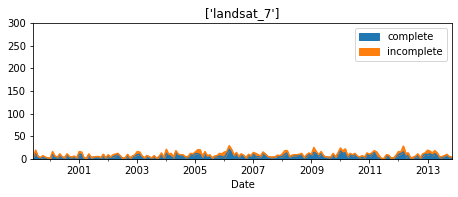

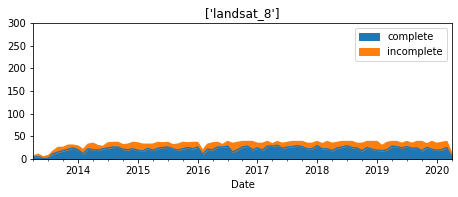

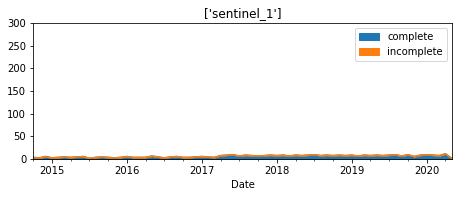

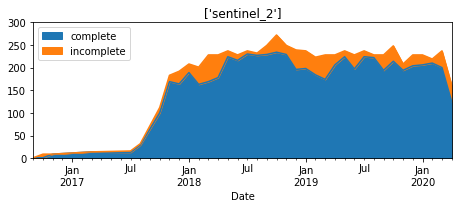

In [100]:
s = ['landsat_7','landsat_8','sentinel_1','sentinel_2']

for i in s:
    i=[i]
    fig, ax = plt.subplots(figsize=(7.5,2.5))
    pd.DataFrame({
        'complete': completed_df[completed_df.Sensor.isin(i)]['Date'].groupby(completed_df['Date'].dt.to_period("M")).agg('count'), 
        'incomplete':incomplete_df[incomplete_df.Sensor.isin(i)]['Date'].groupby(incomplete_df['Date'].dt.to_period("M")).agg('count')}).plot.area(ax=ax)
    ax.set_title(f'{i}');
    ax.set_ylim(0,300)
    fig.show()

for landsat we know there's more likely to be issues while processing certain tiles (due to insufficient training samples due to cloud cover)

In [122]:
lssensor = ['landsat_8']
# lssensor = ['landsat_7']
# lssensor = ['sentinel_2']

In [123]:
df_matched_ls = df_matched[df_matched.Sensor.isin(lssensor)]

In [124]:
tiles = np.unique(df_matched_ls.Tile.values)
tiles

array(['072069', '072071', '072072', '072073', '072074', '073069',
       '073071', '073072', '073073', '074069', '074071', '074072',
       '074073', '075069', '075071', '075072', '075073', '076069',
       '076071'], dtype=object)

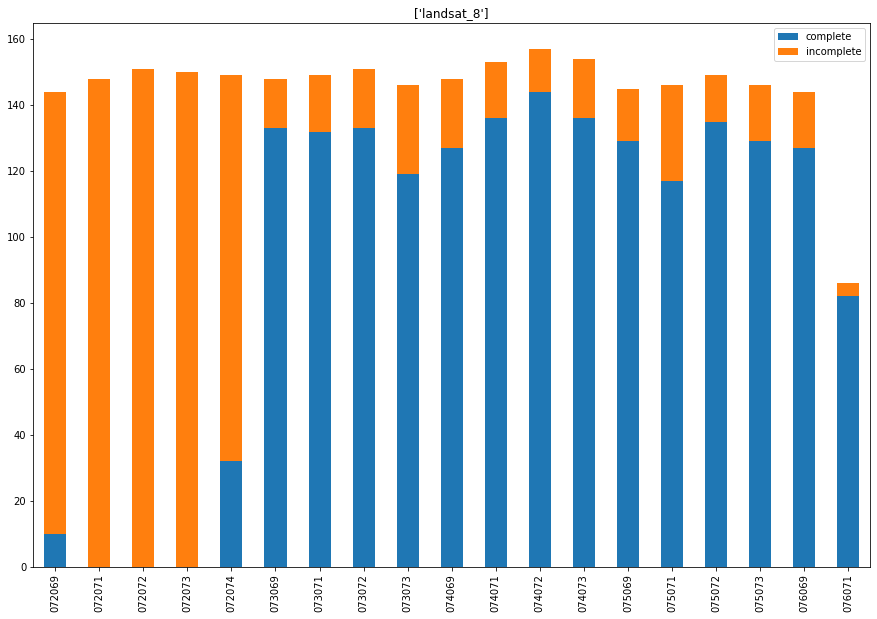

In [125]:
# completed_df.groupby()

completed_df[completed_df.Sensor.isin(lssensor)].groupby('Tile').count().Sensor

pd.DataFrame({
        'complete': completed_df[completed_df.Sensor.isin(lssensor)].groupby('Tile').count().Sensor,
        'incomplete':incomplete_df[incomplete_df.Sensor.isin(lssensor)].groupby('Tile').count().Sensor}).plot.bar(stacked=True, title=f"{lssensor}",figsize=((15,10)))

trend above reinforced thoughts on Landsat failures. Below re-prioritised jobs for Landsat 7 campaign. Based on Landsat 8 failure rate.

In [126]:
list(completed_df[completed_df.Sensor.isin(lssensor)].groupby('Tile').count().sort_values(['Date'], ascending=False).index.values)

['074072',
 '074071',
 '074073',
 '075072',
 '073069',
 '073072',
 '073071',
 '075069',
 '075073',
 '074069',
 '076069',
 '073073',
 '075071',
 '076071',
 '072074',
 '072069']

In [127]:
 order = [
     '074071',
     '074073',
     '075072',
     '073072',
     '075069',
     '075073',
     '074069',
     '076069',
     '073073',
     '073071',
     '075071',
     '076071',
     '072074',
     '072069',
     '073069',
]

In [160]:
jobs_yms = []

for pr in reversed(order):
    jobs_yms = jobs_yms + list(incomplete_df[(incomplete_df.Tile == pr) & (incomplete_df.Sensor == 'landsat_7')].YamlPath_x.values)
len(jobs_yms)

124

In [161]:
# don't want to hve to find this again!
wofssummary_ymls = ['common_sensing/fiji/wofs_summary/wofssummary_20130101_20140101/datacube-metadata.yaml']

In [162]:
la = wofssummary_ymls[0].replace('20130101_20140101','20180101_20190101')
la
d = "/tmp/data/"
td = datetime.today()
td = td.strftime('%Y')+td.strftime('%m')+td.strftime('%d')

In [163]:
with open(f"{d}JOBLIST_{td}_MLWater_L7.txt", 'a') as t:
    for i in jobs_yms:
        t.write("rpush jobMLWater"+" '{"+'"img_yml_path": "'+ i +'", "lab_yml_path": "'+ la +'", "s3_bucket": "public-eo-data", "s3_dir": "common_sensing/fiji/mlwatermasks/"'+"}'" + '\n')

we want to prioritise Sentinel-2 jo lists in similar way

In [146]:
list(np.unique(df_matched[(df_matched.Sensor == 'sentinel_2') & (~df_matched.MatchSceneName_MLWater.notna())].Tile.values))

['T01KAA',
 'T01KAB',
 'T01KAU',
 'T01KAV',
 'T01KBA',
 'T01KBB',
 'T01KBU',
 'T01KBV',
 'T01KCA',
 'T01KCT',
 'T01KCU',
 'T01KCV',
 'T01LAC',
 'T60KWD',
 'T60KWE',
 'T60KWF',
 'T60KWG',
 'T60KXD',
 'T60KXE',
 'T60KXF',
 'T60KXG',
 'T60KYD',
 'T60KYE',
 'T60KYF',
 'T60KYG',
 'T60LYH']

In [324]:
df_matched[(~df_matched.MatchSceneName_MLWater.notna()) & (df_matched.Sensor == 'sentinel_2')]

,YamlPath_x,AOI,Sensor,SceneName,MatchSceneName_MLWater,YamlPath_y,Date,Tile
4694,common_sensing/fiji/sentinel_2/S2A_MSIL2A_2016...,fiji,sentinel_2,S2A_MSIL2A_20160919T223002_T60LYH,NaN,NaN,2016-09-19,T60LYH
4695,common_sensing/fiji/sentinel_2/S2A_MSIL2A_2016...,fiji,sentinel_2,S2A_MSIL2A_20161009T223002_T60KWD,NaN,NaN,2016-10-09,T60KWD
4696,common_sensing/fiji/sentinel_2/S2A_MSIL2A_2016...,fiji,sentinel_2,S2A_MSIL2A_20161009T223002_T60KWE,NaN,NaN,2016-10-09,T60KWE
4697,common_sensing/fiji/sentinel_2/S2A_MSIL2A_2016...,fiji,sentinel_2,S2A_MSIL2A_20161009T223002_T60KWF,NaN,NaN,2016-10-09,T60KWF
4698,common_sensing/fiji/sentinel_2/S2A_MSIL2A_2016...,fiji,sentinel_2,S2A_MSIL2A_20161009T223002_T60KWG,NaN,NaN,2016-10-09,T60KWG
...,...,...,...,...,...,...,...,...
11668,common_sensing/fiji/sentinel_2/S2B_MSIL2A_2020...,fiji,sentinel_2,S2B_MSIL2A_20200420T220919_T01KBV,NaN,NaN,2020-04-20,T01KBV
11669,common_sensing/fiji/sentinel_2/S2B_MSIL2A_2020...,fiji,sentinel_2,S2B_MSIL2A_20200420T220919_T01KCA,NaN,NaN,2020-04-20,T01KCA
11670,common_sensing/fiji/sentinel_2/S2B_MSIL2A_2020...,fiji,sentinel_2,S2B_MSIL2A_20200420T220919_T01KCT,NaN,NaN,2020-04-20,T01KCT
11671,common_sensing/fiji/sentinel_2/S2B_MSIL2A_2020...,fiji,sentinel_2,S2B_MSIL2A_20200420T220919_T01KCU,NaN,NaN,2020-04-20,T01KCU


In [148]:
s2_ordered = [
    'T60KWF',
    'T60KXF',
    'T60KXG',
    'T60KYG',
    'T01KAB',
    'T60KXE',
    'T60KWG',
    'T60KYF',
    'T01KAA',
    'T60KWE',
    'T60KYE',
    'T01KAV',
    'T60LYH',
    'T01LAC',
    'T60KXD',
    'T01KBA',
    'T01KBV',
    'T01KBB',
    'T01KCA',
    'T01KCU',
    'T01KCV',
    'T60KWD',
    'T60KWD',
    'T60KYD',
    'T01KAU',
    'T01KBU',
    'T01KCT',
    'T60LVM',
    'T60LWM'
]

In [149]:
s2_ordered_unq = []
for i in s2_ordered:
    if i not in s2_ordered_unq:
        s2_ordered_unq.append(i)

In [150]:
# check all ordered are present
for i in s2_ordered:
    if i not in list(np.unique(incomplete_df[(incomplete_df.Sensor == 'sentinel_2') & (~incomplete_df.MatchSceneName_MLWater.notna())].Tile.values)):
        print(i)
# check not missed any
for i in list(np.unique(incomplete_df[(incomplete_df.Sensor == 'sentinel_2') & (~incomplete_df.MatchSceneName_MLWater.notna())].Tile.values)):
    if i not in s2_ordered:
        print(i)

T60LVM
T60LWM


In [151]:
s2_jobs_yms = []
for gran in reversed(s2_ordered_unq):
    s2_jobs_yms = s2_jobs_yms + list(incomplete_df[(incomplete_df.Tile == gran) & (incomplete_df.Sensor == 'sentinel_2')].YamlPath_x.values)
len(s2_jobs_yms)

819

In [152]:
with open(f"{d}JOBLIST_{td}_MLWater_S2.txt", 'a') as t:
    for i in s2_jobs_yms:
        t.write("rpush jobMLWater"+" '{"+'"img_yml_path": "'+ i +'", "lab_yml_path": "'+ la +'", "s3_bucket": "public-eo-data", "s3_dir": "common_sensing/fiji/mlwatermasks/"'+"}'" + '\n')

s1 a little simpler. just want incompleted + dual pol first.

In [153]:
s = 'sentinel_1'
with open(f"{d}JOBLIST_{td}_MLWater_S1.txt", 'a') as t:
    for i in sorted(incomplete_df[incomplete_df.Sensor == s].YamlPath_x.values):
        t.write("rpush jobMLWater"+" '{"+'"img_yml_path": "'+ i +'", "lab_yml_path": "'+ la +'", "s3_bucket": "public-eo-data", "s3_dir": "common_sensing/fiji/mlwatermasks/"'+"}'" + '\n')

In [158]:
completed_df[completed_df.Sensor == 'sentinel_1']

,YamlPath_x,AOI,Sensor,SceneName,MatchSceneName_MLWater,YamlPath_y,Date,Tile
4313,common_sensing/fiji/sentinel_1/S1A_IW_GRDH_1SD...,fiji,sentinel_1,S1A_IW_GRDH_1SDV_20150507T063939,S1A_IW_GRDH_1SDV_20150507T063939,common_sensing/fiji/mlwatermasks/S1A_IW_GRDH_1...,2015-05-07,NaN
4314,common_sensing/fiji/sentinel_1/S1A_IW_GRDH_1SD...,fiji,sentinel_1,S1A_IW_GRDH_1SDV_20170213T063946,S1A_IW_GRDH_1SDV_20170213T063946,common_sensing/fiji/mlwatermasks/S1A_IW_GRDH_1...,2017-02-13,NaN
4315,common_sensing/fiji/sentinel_1/S1A_IW_GRDH_1SD...,fiji,sentinel_1,S1A_IW_GRDH_1SDV_20170218T174002,S1A_IW_GRDH_1SDV_20170218T174002,common_sensing/fiji/mlwatermasks/S1A_IW_GRDH_1...,2017-02-18,NaN
4316,common_sensing/fiji/sentinel_1/S1A_IW_GRDH_1SD...,fiji,sentinel_1,S1A_IW_GRDH_1SDV_20170218T174031,S1A_IW_GRDH_1SDV_20170218T174031,common_sensing/fiji/mlwatermasks/S1A_IW_GRDH_1...,2017-02-18,NaN
4317,common_sensing/fiji/sentinel_1/S1A_IW_GRDH_1SD...,fiji,sentinel_1,S1A_IW_GRDH_1SDV_20170225T063946,S1A_IW_GRDH_1SDV_20170225T063946,common_sensing/fiji/mlwatermasks/S1A_IW_GRDH_1...,2017-02-25,NaN
...,...,...,...,...,...,...,...,...
4689,common_sensing/fiji/sentinel_1/S1A_IW_GRDH_1SS...,fiji,sentinel_1,S1A_IW_GRDH_1SSV_20170125T174002,S1A_IW_GRDH_1SSV_20170125T174002,common_sensing/fiji/mlwatermasks/S1A_IW_GRDH_1...,2017-01-25,NaN
4690,common_sensing/fiji/sentinel_1/S1A_IW_GRDH_1SS...,fiji,sentinel_1,S1A_IW_GRDH_1SSV_20170125T174031,S1A_IW_GRDH_1SSV_20170125T174031,common_sensing/fiji/mlwatermasks/S1A_IW_GRDH_1...,2017-01-25,NaN
4691,common_sensing/fiji/sentinel_1/S1B_IW_GRDH_1SD...,fiji,sentinel_1,S1B_IW_GRDH_1SDV_20200104T174000,S1B_IW_GRDH_1SDV_20200104T174000,common_sensing/fiji/mlwatermasks/S1B_IW_GRDH_1...,2020-01-04,NaN
4692,common_sensing/fiji/sentinel_1/S1B_IW_GRDH_1SD...,fiji,sentinel_1,S1B_IW_GRDH_1SDV_20200409T173958,S1B_IW_GRDH_1SDV_20200409T173958,common_sensing/fiji/mlwatermasks/S1B_IW_GRDH_1...,2020-04-09,NaN


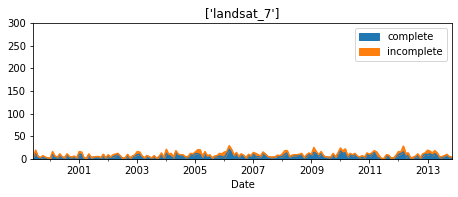

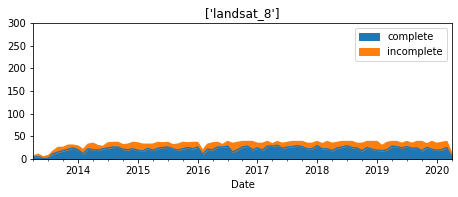

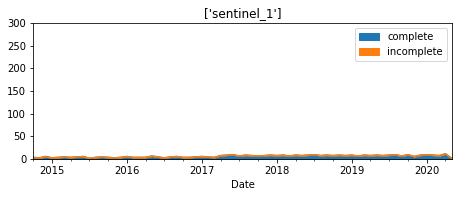

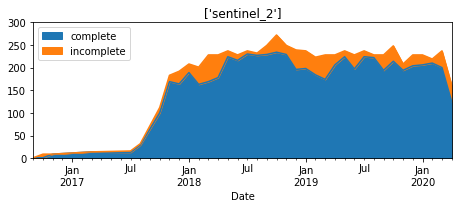

In [159]:
s = ['landsat_7','landsat_8','sentinel_1','sentinel_2']

for i in s:
    i=[i]
    fig, ax = plt.subplots(figsize=(7.5,2.5))
    pd.DataFrame({
        'complete': completed_df[completed_df.Sensor.isin(i)]['Date'].groupby(completed_df['Date'].dt.to_period("M")).agg('count'), 
        'incomplete':incomplete_df[incomplete_df.Sensor.isin(i)]['Date'].groupby(incomplete_df['Date'].dt.to_period("M")).agg('count')}).plot.area(ax=ax)
    ax.set_title(f'{i}');
    ax.set_ylim(0,300)
    fig.show()